In [1]:
import os, sys, time, math, glob, shutil, zipfile, random, hashlib, pickle
from pathlib import Path

SETUP_FLAG = "/content/.colab_setup_done"

# ---------------------------
# 1) Install or fix environment if imports fail (may restart runtime)
# ---------------------------
def ensure_env():
    try:
        import numpy as np, cv2, tensorflow as tf
        return True
    except Exception as e:
        print("Import error or incompatible binaries detected:", repr(e))
        print("Installing compatible numpy + opencv + supporting packages. Runtime will restart.")
        os.system("pip uninstall -y opencv-python opencv-python-headless >/dev/null 2>&1 || true")
        os.system("pip install -q --upgrade pip")
        # Pick numpy compatible with many TF/OpenCV combinations in Colab
        os.system("pip install -q numpy==1.25.2")
        os.system("pip install -q opencv-python-headless==4.7.0.72 scikit-learn matplotlib imageio-ffmpeg tqdm")
        Path(SETUP_FLAG).write_text("installed\n")
        print("Restarting runtime to load native extensions (this will disconnect your session)...")
        os.kill(os.getpid(), 9)

if not os.path.exists(SETUP_FLAG):
    ensure_env()

In [2]:
import numpy as np, cv2
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, callbacks
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB4
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import itertools
import json

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision on GPU (optional)
try:
    if tf.config.list_physical_devices('GPU'):
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision (mixed_float16) enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

Mixed precision (mixed_float16) enabled.


In [3]:
CACHE_DIR = "/content/deepfake_cache"
MODEL_PATH = "/content/deepfake_t4.h5"
DATA_ROOT = "/content/deepfake_dataset"
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(DATA_ROOT, exist_ok=True)

# Try to mount Google Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DRIVE_ROOT = "/content/drive/MyDrive"
    print("Google Drive mounted.")
except Exception as e:
    DRIVE_ROOT = None
    print("Drive mount skipped or unavailable:", e)

def find_and_extract_candidates(names_list, target_subdir):
    """
    Search for any archive name in names_list and extract .mp4 files into DATA_ROOT/target_subdir.
    """
    target_dir = os.path.join(DATA_ROOT, target_subdir)
    os.makedirs(target_dir, exist_ok=True)
    search_roots = []
    if DRIVE_ROOT and os.path.exists(DRIVE_ROOT):
        search_roots.append(DRIVE_ROOT)
    search_roots.append(os.getcwd())
    found_any = False
    for root in search_roots:
        for path, dirs, files in os.walk(root):
            for fname in names_list:
                if fname in files:
                    zip_path = os.path.join(path, fname)
                    print(f"Found {fname} at {zip_path}. Extracting .mp4 files to {target_dir} ...")
                    try:
                        with zipfile.ZipFile(zip_path, 'r') as z:
                            for member in z.namelist():
                                if member.lower().endswith('.mp4'):
                                    member_name = os.path.basename(member)
                                    if not member_name:
                                        continue
                                    dest = os.path.join(target_dir, member_name)
                                    with z.open(member) as source, open(dest, "wb") as destf:
                                        shutil.copyfileobj(source, destf)
                        found_any = True
                    except zipfile.BadZipFile:
                        print(f"Error: {zip_path} is not a valid zip file.")
                    # stop searching other zip names in this folder once one is handled
            # continue walking
    if not found_any:
        print(f"Warning: none of {names_list} were found under {search_roots}.")
    return found_any

# Prefer real.zip & fake.zip; fall back to r.zip/f.zip
find_and_extract_candidates(["real.zip","r.zip"], "real/real")
find_and_extract_candidates(["fake.zip","f.zip"], "fake/fakes")

# Show counts
real_count = len(glob.glob(os.path.join(DATA_ROOT,"real","real","*.mp4")))
fake_count = len(glob.glob(os.path.join(DATA_ROOT,"fake","fakes","*.mp4")))
print(f"Videos after extraction: real={real_count}, fake={fake_count}")
if real_count + fake_count == 0:
    raise SystemExit("No .mp4 files were found in the extracted dataset. Please upload real.zip/fake.zip (or r.zip/f.zip) to Drive or /content.")

Mounted at /content/drive
Google Drive mounted.
Found real.zip at /content/drive/MyDrive/real.zip. Extracting .mp4 files to /content/deepfake_dataset/real/real ...
Found real.zip at /content/drive/MyDrive/real.zip. Extracting .mp4 files to /content/deepfake_dataset/real/real ...
Found fake.zip at /content/drive/MyDrive/fake.zip. Extracting .mp4 files to /content/deepfake_dataset/fake/fakes ...
Found fake.zip at /content/drive/MyDrive/fake.zip. Extracting .mp4 files to /content/deepfake_dataset/fake/fakes ...
Videos after extraction: real=363, fake=1002


In [4]:
class PatentAlignedDeepfakeDetector:
    def __init__(self, max_frames=6, resize_to=(224,224), ascii_grid=(80,40),
                 ascii_stats_dim=32, cache_dir=CACHE_DIR):
        self.max_frames = max_frames
        self.resize_to = resize_to
        self.ascii_grid = ascii_grid
        self.ascii_stats_dim = ascii_stats_dim
        self.ASCII_CHARS = "@%#*+=-:. "
        self.intensity_bins = np.linspace(0, 255, len(self.ASCII_CHARS))
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _cache_key(self, video_path):
        return os.path.join(self.cache_dir, hashlib.md5(video_path.encode()).hexdigest()+".pkl")

    def vectorized_ascii_conversion(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        H, W = gray.shape
        gh, gw = self.ascii_grid
        if gh <= 0 or gw <= 0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        crop_h, crop_w = (H//gh)*gh, (W//gw)*gw
        gray = gray[:crop_h,:crop_w] if crop_h>0 and crop_w>0 else gray
        if crop_h==0 or crop_w==0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        cell_h, cell_w = crop_h//gh, crop_w//gw
        try:
            cells = gray.reshape(gh,cell_h,gw,cell_w)
            means = cells.mean(axis=(1,3))
            ascii_idx = np.digitize(means, self.intensity_bins)-1
            ascii_idx = np.clip(ascii_idx, 0, len(self.ASCII_CHARS)-1)
            ascii_vals = np.array([ord(self.ASCII_CHARS[i]) for i in ascii_idx.flatten()]).reshape(ascii_idx.shape)
            ascii_img = np.stack([ascii_vals]*3,axis=-1).astype(np.float32)
            return cv2.resize(ascii_img, self.resize_to)
        except Exception:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)

    def compute_ascii_stats(self, ascii_frames):
        ent = []
        for f in ascii_frames:
            flat = f[:,:,0].flatten()
            if len(flat)<3:
                ent.append((0.0,0.0))
                continue
            ent.append((float(np.std(flat)), float(np.mean(flat))))
        if len(ent)==0:
            packed = np.array([0.0,0.0])
        else:
            packed = np.mean(ent,axis=0)
        reps = int(np.ceil(self.ascii_stats_dim/packed.size))
        return np.tile(packed,reps)[:self.ascii_stats_dim].astype(np.float32)

    def extract_frames_dual_path(self, video_path):
        cache_file = self._cache_key(video_path)
        if os.path.exists(cache_file):
            try:
                return pickle.load(open(cache_file,"rb"))
            except Exception:
                pass

        cap = cv2.VideoCapture(video_path)
        pixel, ascii_ = [], []
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if total > self.max_frames:
            idxs = np.linspace(0, total-1, self.max_frames, dtype=int)
        elif total > 0:
            idxs = range(0, min(total, self.max_frames))
        else:
            idxs = []
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, f = cap.read()
            if not ret:
                continue
            f = cv2.resize(f, self.resize_to)[:,:,::-1]
            pixel.append(f)
            ascii_.append(self.vectorized_ascii_conversion(f))
        cap.release()
        while len(pixel) < self.max_frames:
            if pixel:
                pixel.append(pixel[-1].copy())
                ascii_.append(ascii_[-1].copy())
            else:
                pixel.append(np.zeros((*self.resize_to,3), np.uint8))
                ascii_.append(np.zeros((*self.resize_to,3), np.uint8))
        pixel = np.stack(pixel).astype(np.float32)
        ascii_ = np.stack(ascii_).astype(np.float32)
        stats = self.compute_ascii_stats(ascii_)
        data = (pixel, ascii_, stats)
        try:
            pickle.dump(data, open(cache_file, "wb"))
        except Exception:
            pass
        return data

    def build_patent_aligned_model(self):
        T, H, W = self.max_frames, *self.resize_to
        pix_in = Input((T,H,W,3), name="pixel_input")
        asc_in = Input((T,H,W,3), name="ascii_input")
        stats_in = Input((self.ascii_stats_dim,), name="ascii_stats_input")

        irv2 = InceptionResNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        effb4 = EfficientNetB4(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        irv2.trainable = False
        effb4.trainable = False

        pix = layers.TimeDistributed(layers.Lambda(lambda x: irv2(irv2_preprocess(x))))(pix_in)
        asc = layers.TimeDistributed(layers.Lambda(lambda x: effb4(eff_preprocess(x))))(asc_in)
        stats = layers.RepeatVector(T)(layers.Dense(32, activation="relu")(stats_in))
        fused = layers.Concatenate()([pix, asc, stats])

        temporal = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(fused)
        frame_logits = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="frame_logits")(temporal)
        video_pred = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name="video_pred")(frame_logits)

        self.model = Model([pix_in, asc_in, stats_in], [video_pred, frame_logits])
        return self.model

    def _temporal_penalty_loss(self, y_true, frame_logits):
        diffs = frame_logits[:,1:,:] - frame_logits[:,:-1,:]
        return tf.reduce_mean(tf.abs(diffs))

    def compile_model(self, lr=1e-4, temporal_loss_weight=0.1):
        bce = tf.keras.losses.BinaryCrossentropy()
        def vloss(y_true, y_pred): return bce(y_true, y_pred)
        def tloss(y_true, y_pred): return self._temporal_penalty_loss(y_true, y_pred)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss={"video_pred": vloss, "frame_logits": tloss},
            loss_weights={"video_pred": 1.0, "frame_logits": temporal_loss_weight},
            metrics={"video_pred": [tf.keras.metrics.BinaryAccuracy(name="acc")]}
        )

    def dual_path_generator(self, paths, labels, batch_size=2, augment=False):
        while True:
            data = list(zip(paths, labels)); random.shuffle(data)
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                Xp, Xa, Xs, Y = [], [], [], []
                for vp, lbl in batch:
                    pf, af, st = self.extract_frames_dual_path(vp)
                    if augment and random.random() > 0.5:
                        pf, af = pf[:, ::-1, :, :], af[:, ::-1, :, :]
                    Xp.append(pf.astype("float32"))
                    Xa.append(af.astype("float32"))
                    Xs.append(st.astype("float32"))
                    Y.append(lbl)
                Xp = np.stack(Xp)
                Xa = np.stack(Xa)
                Xs = np.stack(Xs)
                Yv = np.array(Y, dtype=np.float32).reshape(-1,1)
                Yf = np.zeros((len(Y), self.max_frames, 1), dtype=np.float32)
                yield [Xp, Xa, Xs], {"video_pred": Yv, "frame_logits": Yf}

In [5]:
def load_dataset(base_dir=DATA_ROOT, test_size=0.2):
    real_dir = os.path.join(base_dir, "real", "real")
    fake_dir = os.path.join(base_dir, "fake", "fakes")
    real = sorted(glob.glob(os.path.join(real_dir, "*.mp4")))
    fake = sorted(glob.glob(os.path.join(fake_dir, "*.mp4")))
    print(f"Found {len(real)} real videos, {len(fake)} fake videos")
    if len(real) + len(fake) == 0:
        raise FileNotFoundError("No mp4 files found.")
    paths = real + fake
    labels = [1]*len(real) + [0]*len(fake)
    strat = labels if len(set(labels))>1 else None
    return train_test_split(paths, labels, test_size=test_size, stratify=strat, random_state=SEED)

def warmup_cache(detector, paths, label="train"):
    print(f"\n[Warmup] Caching {len(paths)} {label} videos ...")
    for idx, vp in enumerate(paths):
        try:
            _ = detector.extract_frames_dual_path(vp)
        except Exception as e:
            print(f"[WARN] Failed caching {vp}: {e}")
        if (idx + 1) % 50 == 0:
            print(f"  Cached {idx+1}/{len(paths)} videos")
    print(f"[Warmup] Done caching {label}\n")

def plot_history(history):
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if "loss" in hist:
        plt.plot(hist["loss"], label="train_total_loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_total_loss")
    if "video_pred_loss" in hist:
        plt.plot(hist["video_pred_loss"], label="train_video_loss")
    if "val_video_pred_loss" in hist:
        plt.plot(hist["val_video_pred_loss"], label="val_video_loss")
    plt.title("Losses")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    if "video_pred_acc" in hist:
        plt.plot(hist["video_pred_acc"], label="train_video_acc")
    if "val_video_pred_acc" in hist:
        plt.plot(hist["val_video_pred_acc"], label="val_video_acc")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_single(detector, video_path):
    pixel_frames, ascii_frames, stats = detector.extract_frames_dual_path(video_path)
    Xp = np.expand_dims(pixel_frames.astype("float32"), 0)
    Xa = np.expand_dims(ascii_frames.astype("float32"), 0)
    Xs = np.expand_dims(stats.astype("float32"), 0)
    preds = detector.model.predict([Xp, Xa, Xs], verbose=0)
    video_pred, frame_preds = preds
    video_score = float(video_pred[0][0])
    frame_scores = frame_preds[0,:,0]
    return video_score, frame_scores

def evaluate_on_validation(detector, val_paths, val_labels, plot_figures=True):
    y_true, y_scores = [], []
    for vp, lbl in zip(val_paths, val_labels):
        try:
            score, _ = predict_single(detector, vp)
        except Exception as e:
            print(f"[WARN] predict failed for {vp}: {e}")
            score = 0.5
        y_true.append(lbl)
        y_scores.append(score)
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = (y_scores >= 0.5).astype(int)
    try:
        auc_score = roc_auc_score(y_true, y_scores)
    except Exception:
        auc_score = float('nan')
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    acc = (y_pred == y_true).mean()
    print("\n=== Evaluation on validation set ===")
    print(f"Samples: {len(y_true)}  Accuracy: {acc:.4f}  AUC: {auc_score:.4f}")
    print("\nClassification report:\n", cr)
    print("\nConfusion matrix:\n", cm)
    if plot_figures:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc_val = auc(fpr, tpr)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
            plt.plot([0,1],[0,1],"--")
            plt.title("ROC curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print("ROC plot failed:", e)
        plt.figure(figsize=(5,4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["fake(0)","real(1)"])
        plt.yticks(tick_marks, ["fake(0)","real(1)"])
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    return {"accuracy": acc, "auc": auc_score, "confusion_matrix": cm, "report": cr, "y_true": y_true, "y_scores": y_scores}

In [6]:
def run_training(base_dir=DATA_ROOT, epochs=8, batch_size=2, resume=True):
    train_p, val_p, train_l, val_l = load_dataset(base_dir)
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    det_model = det.build_patent_aligned_model()
    det.compile_model()
    print("Warmup cache (this will process videos and can take time)...")
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p, label="val")
    # Compute class weights for video_pred output
    labels_all = np.array(train_l)
    classes = np.unique(labels_all)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=labels_all)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}
    keras_class_weight = {"video_pred": class_weight_dict}
    print("Using class weights:", keras_class_weight)
    train_gen = det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)
    val_gen = det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)
    steps = max(1, math.ceil(len(train_p) / batch_size))
    val_steps = max(1, math.ceil(len(val_p) / batch_size))
    cb = [
        callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_video_pred_acc", verbose=1),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5, patience=2, verbose=1)
    ]
    history = det.model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        workers=1,
        use_multiprocessing=False,
        class_weight=keras_class_weight
    )
    if os.path.exists(MODEL_PATH):
        det.model.load_weights(MODEL_PATH)
    print("Training complete. Model saved at:", MODEL_PATH)
    return det, history, (train_p, val_p, train_l, val_l)

In [7]:
import tensorflow as tf

def run_training(base_dir, epochs=10, batch_size=2, resume=True):
    """
    Build detector, warmup cache, create tf.data.Dataset wrappers around
    the existing Python generator, and train.
    Returns: det, history, (train_p, val_p, train_l, val_l)
    """
    # 1) dataset splits
    train_p, val_p, train_l, val_l = load_dataset(base_dir)

    # 2) build detector and model
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    model = det.build_patent_aligned_model()
    det.compile_model()

    # 3) warmup cache (persistent)
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p,   label="val")

    # 4) resume weights if requested
    if resume and os.path.exists(MODEL_PATH):
        print(f"\n[Resume] Loading existing model from {MODEL_PATH}")
        det.model.load_weights(MODEL_PATH)

    # 5) create tf.data.Dataset from generator with explicit output_signature
    T = det.max_frames
    H, W = det.resize_to
    ascii_dim = det.ascii_stats_dim

    # output_signature mirrors what the generator yields:
    # inputs: [Xp, Xa, Xs] -> shapes: (batch, T, H, W, 3), (batch, T, H, W, 3), (batch, ascii_dim)
    # outputs: {"video_pred": (batch,1), "frame_logits": (batch, T, 1)}
    input_signature = (
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),   # Xp
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),   # Xa
        tf.TensorSpec(shape=(None, ascii_dim), dtype=tf.float32)     # Xs
    )
    output_signature = {
        "video_pred": tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        "frame_logits": tf.TensorSpec(shape=(None, T, 1), dtype=tf.float32)
    }
    full_signature = (input_signature, output_signature)

    # generator factories (no args)
    def train_gen_factory():
        return det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)

    def val_gen_factory():
        return det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)

    # Build datasets
    train_ds = tf.data.Dataset.from_generator(
        train_gen_factory,
        output_signature=full_signature
    )
    val_ds = tf.data.Dataset.from_generator(
        val_gen_factory,
        output_signature=full_signature
    )

    # Optional: prefetch to improve throughput
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

    steps = max(1, len(train_p) // batch_size)
    val_steps = max(1, len(val_p) // batch_size)

    cb = [
        callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True,
                                  monitor="val_video_pred_acc", verbose=1),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3,
                                restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5,
                                    patience=2, verbose=1)
    ]

    # 6) Fit (no workers/use_multiprocessing)
    history = det.model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        verbose=1
    )

    print(f"\n✅ Training complete. Best model saved at: {MODEL_PATH}")
    return det, history, (train_p, val_p, train_l, val_l)

In [8]:
import tensorflow as tf
import shutil, time, os
from tensorflow.keras import callbacks

class CopyToDriveCallback(tf.keras.callbacks.Callback):
    """Copy a local checkpoint file to Drive at the end of every epoch (if present)."""
    def __init__(self, src_path, dst_path, copy_on_epoch_end=True):
        super().__init__()
        self.src = src_path
        self.dst = dst_path
        self.copy_on_epoch_end = copy_on_epoch_end

    def on_epoch_end(self, epoch, logs=None):
        if self.copy_on_epoch_end and os.path.exists(self.src):
            try:
                shutil.copy(self.src, self.dst)
                now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
                print(f"[CopyToDrive] Epoch {epoch+1}: copied checkpoint to Drive at {self.dst} ({now})")
            except Exception as e:
                print(f"[CopyToDrive] Failed to copy checkpoint to Drive: {e}")

def run_training(base_dir, epochs=10, batch_size=2, resume=True, local_ckpt="/content/deepfake_t4_local.h5", drive_ckpt="/content/drive/MyDrive/deepfake_t4.h5"):
    """
    Build detector, warmup cache, create tf.data.Dataset wrappers around the existing generator,
    train, and checkpoint to local_ckpt while copying it to drive_ckpt each epoch (if drive_ckpt is not None).
    Returns: det, history, (train_p, val_p, train_l, val_l)
    """
    # 1) dataset splits
    train_p, val_p, train_l, val_l = load_dataset(base_dir)

    # 2) build detector and model
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    model = det.build_patent_aligned_model()
    det.compile_model()

    # 3) warmup cache (persistent)
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p,   label="val")

    # 4) resume from a drive checkpoint if requested (prefer drive_ckpt then fallback local)
    if resume:
        if drive_ckpt and os.path.exists(drive_ckpt):
            try:
                det.model.load_weights(drive_ckpt)
                print(f"[Resume] Loaded weights from drive checkpoint: {drive_ckpt}")
            except Exception as e:
                print("[Resume] Failed to load drive_ckpt:", e)
        elif os.path.exists(local_ckpt):
            try:
                det.model.load_weights(local_ckpt)
                print(f"[Resume] Loaded weights from local checkpoint: {local_ckpt}")
            except Exception as e:
                print("[Resume] Failed to load local_ckpt:", e)

    # 5) prepare tf.data.Dataset.from_generator with explicit output_signature
    T = det.max_frames
    H, W = det.resize_to
    ascii_dim = det.ascii_stats_dim

    inputs_signature = (
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, T, H, W, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, ascii_dim), dtype=tf.float32)
    )
    outputs_signature = {
        "video_pred": tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        "frame_logits": tf.TensorSpec(shape=(None, T, 1), dtype=tf.float32)
    }
    full_signature = (inputs_signature, outputs_signature)

    def train_gen_adapter():
        gen = det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)
        for batch in gen:
            inputs_list, outputs = batch
            yield (inputs_list[0], inputs_list[1], inputs_list[2]), outputs

    def val_gen_adapter():
        gen = det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)
        for batch in gen:
            inputs_list, outputs = batch
            yield (inputs_list[0], inputs_list[1], inputs_list[2]), outputs

    train_ds = tf.data.Dataset.from_generator(train_gen_adapter, output_signature=full_signature)
    val_ds   = tf.data.Dataset.from_generator(val_gen_adapter, output_signature=full_signature)

    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

    steps = max(1, len(train_p) // batch_size)
    val_steps = max(1, len(val_p) // batch_size)

    # callbacks: checkpoint locally (fast) and optionally copy to Drive each epoch
    cb = [
        callbacks.ModelCheckpoint(local_ckpt, save_best_only=True,
                                  monitor="val_video_pred_acc", verbose=1, mode="max"),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3,
                                restore_best_weights=True, mode="max"),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5,
                                    patience=2, verbose=1, mode="max")
    ]

    # Attach the CopyToDrive callback if drive_ckpt is supplied
    if drive_ckpt:
        # ensure destination dir exists (safe)
        os.makedirs(os.path.dirname(drive_ckpt), exist_ok=True)
        cb.append(CopyToDriveCallback(local_ckpt, drive_ckpt))

    # 6) Fit
    history = det.model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        verbose=1
    )

    print(f"\n✅ Training complete. Best model saved at: {local_ckpt} (and copied to {drive_ckpt} if available)")
    return det, history, (train_p, val_p, train_l, val_l)

In [9]:
# --- Training invocation (use this cell after defining the updated run_training) ---
from google.colab import drive
import os

# Mount Google Drive (will prompt)
drive.mount('/content/drive')

# Config
DATA_ROOT = "/content/deepfake_dataset"
EPOCHS = 11
BATCH_SIZE = 2
RESUME = True

# Path strategy (best practice: local checkpoint + persistent Drive copy)
LOCAL_MODEL_PATH = "/content/deepfake_t4_local.h5"               # fast local checkpoint
DRIVE_MODEL_PATH = "/content/drive/MyDrive/deepfake_t4.h5"      # persistent copy on Drive
DRIVE_CACHE_DIR  = "/content/drive/MyDrive/deepfake_cache"      # optional persistent cache

# Make Drive cache dir if you want caching persisted
os.makedirs(DRIVE_CACHE_DIR, exist_ok=True)

# Set the global CACHE_DIR used by the detector class (so cache persists if desired)
CACHE_DIR = DRIVE_CACHE_DIR  # or keep "/content/deepfake_cache" if you prefer ephemeral cache

# Run training (local checkpoint will be copied to Drive each epoch)
detector, history, (train_p, val_p, train_l, val_l) = run_training(
    base_dir=DATA_ROOT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    resume=RESUME,
    local_ckpt=LOCAL_MODEL_PATH,
    drive_ckpt=DRIVE_MODEL_PATH
)

print("Training finished. Local checkpoint:", LOCAL_MODEL_PATH)
print("Drive checkpoint copy:", DRIVE_MODEL_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 363 real videos, 1002 fake videos
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

[Warmup] Caching 1092 train videos ...
  Cached 50/1092 videos
  Cached 100/1092 videos
  Cached 150/1092 videos
  Cached 200/1092 videos
  Cached 250/1092 videos
  Cached 300/1092 videos
  Cached 350/1092 videos
  Cached 400/1092 videos
  Cached 450/1092 videos
  Cached 500/1092 videos
  Cached 550/1092 videos
  Cached 600/1092 videos
  Cached 650/1092 videos
  Cached 700/1092 videos
  Cached 750/1092 videos
  Cached 800/1092 videos
  Cached 850/1092 videos
  Cached 900/1092 videos
  Cached 950/1092 videos
  Cached 1000/1092 videos
  Cached 1050/1092 videos
[Warmup] Done caching train


[Warmup] Caching 273 val videos ...
  Cached 50/273 videos
  Cached 100/273 videos
  Cached 150/273 videos
  Cached 200/273 videos


[CopyToDrive] Epoch 1: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 06:48:21)
546/546 ━━━━━━━━━━━━━━━━━━━━ 552s 554ms/step - frame_logits_loss: 0.0224 - loss: 0.6869 - video_pred_acc: 0.6888 - video_pred_loss: 0.6847 - val_frame_logits_loss: 0.0365 - val_loss: 0.5421 - val_video_pred_acc: 0.7316 - val_video_pred_loss: 0.5384 - learning_rate: 1.0000e-04
Epoch 2/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - frame_logits_loss: 0.0429 - loss: 0.5047 - video_pred_acc: 0.7757 - video_pred_loss: 0.5004
Epoch 2: val_video_pred_acc improved from 0.73162 to 0.82721, saving model to /content/deepfake_t4_local.h5


[CopyToDrive] Epoch 2: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 06:52:42)
546/546 ━━━━━━━━━━━━━━━━━━━━ 261s 478ms/step - frame_logits_loss: 0.0429 - loss: 0.5047 - video_pred_acc: 0.7757 - video_pred_loss: 0.5005 - val_frame_logits_loss: 0.0593 - val_loss: 0.4770 - val_video_pred_acc: 0.8272 - val_video_pred_loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 3/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - frame_logits_loss: 0.0550 - loss: 0.4766 - video_pred_acc: 0.8221 - video_pred_loss: 0.4711
Epoch 3: val_video_pred_acc improved from 0.82721 to 0.85662, saving model to /content/deepfake_t4_local.h5


[CopyToDrive] Epoch 3: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 06:56:26)
546/546 ━━━━━━━━━━━━━━━━━━━━ 224s 410ms/step - frame_logits_loss: 0.0550 - loss: 0.4766 - video_pred_acc: 0.8221 - video_pred_loss: 0.4711 - val_frame_logits_loss: 0.0621 - val_loss: 0.4396 - val_video_pred_acc: 0.8566 - val_video_pred_loss: 0.4334 - learning_rate: 1.0000e-04
Epoch 4/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - frame_logits_loss: 0.0576 - loss: 0.4319 - video_pred_acc: 0.8238 - video_pred_loss: 0.4262
Epoch 4: val_video_pred_acc did not improve from 0.85662
[CopyToDrive] Epoch 4: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:00:47)
546/546 ━━━━━━━━━━━━━━━━━━━━ 262s 480ms/step - frame_logits_loss: 0.0576 - loss: 0.4319 - video_pred_acc: 0.8238 - video_pred_loss: 0.4261 - val_frame_logits_loss: 0.0726 - val_loss: 0.5545 - val_video_pred_acc: 0.6912 - val_video_pred_loss: 0.5473 - learning_rate: 1.0000e-04
Epoch 5/11
546/

[CopyToDrive] Epoch 6: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:08:56)
546/546 ━━━━━━━━━━━━━━━━━━━━ 263s 481ms/step - frame_logits_loss: 0.0531 - loss: 0.3561 - video_pred_acc: 0.8795 - video_pred_loss: 0.3508 - val_frame_logits_loss: 0.0462 - val_loss: 0.3447 - val_video_pred_acc: 0.8934 - val_video_pred_loss: 0.3400 - learning_rate: 5.0000e-05
Epoch 7/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - frame_logits_loss: 0.0447 - loss: 0.2952 - video_pred_acc: 0.9109 - video_pred_loss: 0.2907
Epoch 7: val_video_pred_acc improved from 0.89338 to 0.89706, saving model to /content/deepfake_t4_local.h5


[CopyToDrive] Epoch 7: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:13:18)
546/546 ━━━━━━━━━━━━━━━━━━━━ 262s 480ms/step - frame_logits_loss: 0.0447 - loss: 0.2952 - video_pred_acc: 0.9109 - video_pred_loss: 0.2907 - val_frame_logits_loss: 0.0416 - val_loss: 0.3350 - val_video_pred_acc: 0.8971 - val_video_pred_loss: 0.3309 - learning_rate: 5.0000e-05
Epoch 8/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - frame_logits_loss: 0.0429 - loss: 0.2866 - video_pred_acc: 0.9085 - video_pred_loss: 0.2823
Epoch 8: val_video_pred_acc did not improve from 0.89706
[CopyToDrive] Epoch 8: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:17:39)
546/546 ━━━━━━━━━━━━━━━━━━━━ 262s 480ms/step - frame_logits_loss: 0.0429 - loss: 0.2866 - video_pred_acc: 0.9085 - video_pred_loss: 0.2823 - val_frame_logits_loss: 0.0355 - val_loss: 0.3209 - val_video_pred_acc: 0.8971 - val_video_pred_loss: 0.3174 - learning_rate: 5.0000e-05
Epoch 9/11
546/

[CopyToDrive] Epoch 10: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:26:27)
546/546 ━━━━━━━━━━━━━━━━━━━━ 265s 485ms/step - frame_logits_loss: 0.0371 - loss: 0.2403 - video_pred_acc: 0.9223 - video_pred_loss: 0.2366 - val_frame_logits_loss: 0.0351 - val_loss: 0.2979 - val_video_pred_acc: 0.9154 - val_video_pred_loss: 0.2944 - learning_rate: 2.5000e-05
Epoch 11/11
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - frame_logits_loss: 0.0356 - loss: 0.2318 - video_pred_acc: 0.9286 - video_pred_loss: 0.2282
Epoch 11: val_video_pred_acc did not improve from 0.91544
[CopyToDrive] Epoch 11: copied checkpoint to Drive at /content/drive/MyDrive/deepfake_t4.h5 (2025-09-02 07:30:45)
546/546 ━━━━━━━━━━━━━━━━━━━━ 259s 474ms/step - frame_logits_loss: 0.0356 - loss: 0.2318 - video_pred_acc: 0.9286 - video_pred_loss: 0.2282 - val_frame_logits_loss: 0.0344 - val_loss: 0.3015 - val_video_pred_acc: 0.9154 - val_video_pred_loss: 0.2980 - learning_rate: 2.5000e-05

✅ Training

In [11]:
# Save final model + weights using the same paths/dirs you used for training
# Assumes the following variables already exist in the notebook:
#   LOCAL_MODEL_PATH, DRIVE_MODEL_PATH, DRIVE_CACHE_DIR, CACHE_DIR
# and detector, history are present after training.

import os
import shutil
from tensorflow.keras.models import load_model

# --- Derive final paths (keeps the same Drive folder used by DRIVE_MODEL_PATH) ---
FINAL_LOCAL = "/content/final.h5"  # user-requested final filename on Colab local FS
FINAL_WEIGHTS_LOCAL = "/content/final.weights.h5"

# If DRIVE_MODEL_PATH exists in training cell, place final files in same Drive folder
drive_folder = os.path.dirname(DRIVE_MODEL_PATH) if 'DRIVE_MODEL_PATH' in globals() else "/content/drive/MyDrive"
FINAL_DRIVE = os.path.join(drive_folder, "final.h5")
FINAL_WEIGHTS_DRIVE = os.path.join(drive_folder, "final.weights.h5")

# Ensure parent directories exist (Drive was mounted earlier in your training cell)
os.makedirs(os.path.dirname(FINAL_LOCAL), exist_ok=True)
os.makedirs(os.path.dirname(FINAL_DRIVE), exist_ok=True)

# 1) Copy local checkpoint (if any) to the Drive checkpoint path used during training
try:
    if 'LOCAL_MODEL_PATH' in globals() and os.path.exists(LOCAL_MODEL_PATH):
        print(f"Copying local checkpoint {LOCAL_MODEL_PATH} -> {DRIVE_MODEL_PATH}")
        shutil.copy(LOCAL_MODEL_PATH, DRIVE_MODEL_PATH)
        print("Checkpoint copy complete.")
    else:
        print("No local checkpoint found at LOCAL_MODEL_PATH; skipping checkpoint copy.")
except Exception as e:
    print("Warning: could not copy local checkpoint to Drive:", e)

# 2) Save final full model as legacy HDF5 named final.h5 (this will emit the .h5 warning)
try:
    print(f"Saving full model locally as: {FINAL_LOCAL}")
    detector.model.save(FINAL_LOCAL)
    print(f"Saving full model to Drive as: {FINAL_DRIVE}")
    detector.model.save(FINAL_DRIVE)
    print("Full model saved to both local and Drive.")
except Exception as e:
    print("Error saving full model as .h5 (falling back to .keras):", e)
    # Fallback: save in recommended .keras format
    try:
        FALLBACK_LOCAL = FINAL_LOCAL.replace(".h5", ".keras")
        FALLBACK_DRIVE = FINAL_DRIVE.replace(".h5", ".keras")
        print(f"Saving fallback .keras model to {FALLBACK_LOCAL} and {FALLBACK_DRIVE}")
        detector.model.save(FALLBACK_LOCAL)
        detector.model.save(FALLBACK_DRIVE)
        print("Fallback .keras save successful.")
    except Exception as e2:
        print("Fallback save also failed:", e2)

# 3) Save weights in HDF5 weights format (filename must end with .weights.h5)
try:
    print(f"Saving weights locally as: {FINAL_WEIGHTS_LOCAL}")
    detector.model.save_weights(FINAL_WEIGHTS_LOCAL)
    print(f"Saving weights to Drive as: {FINAL_WEIGHTS_DRIVE}")
    detector.model.save_weights(FINAL_WEIGHTS_DRIVE)
    print("Weights saved to both local and Drive.")
except Exception as e:
    print("Error saving weights (.weights.h5):", e)

# 4) Save training history as pickle alongside Drive folder (optional)
try:
    import pickle
    HISTORY_LOCAL = "/content/history.pkl"
    HISTORY_DRIVE = os.path.join(drive_folder, "history.pkl")
    with open(HISTORY_LOCAL, "wb") as f:
        pickle.dump(history.history, f)
    with open(HISTORY_DRIVE, "wb") as f:
        pickle.dump(history.history, f)
    print(f"Saved training history to: {HISTORY_LOCAL} and {HISTORY_DRIVE}")
except Exception as e:
    print("Warning: could not save training history:", e)

# 5) Summary printout & quick load examples
print("\nSummary of saved artifacts:")
print(" - Local final model:", FINAL_LOCAL, "(legacy .h5; Keras may warn)")
print(" - Drive final model:", FINAL_DRIVE)
print(" - Local weights:", FINAL_WEIGHTS_LOCAL)
print(" - Drive weights:", FINAL_WEIGHTS_DRIVE)
print(" - Drive checkpoint used during training (if copied):", DRIVE_MODEL_PATH)

print("\nExample to load the legacy .h5 full model later:")
print(f"  from tensorflow.keras.models import load_model\n  model = load_model('{FINAL_DRIVE}')")

print("\nExample to load weights into a constructed model later:")
print(f"  model = <your_model_constructor>()\n  model.load_weights('{FINAL_WEIGHTS_DRIVE}')")

# If you want the model also saved in native Keras (.keras) format, uncomment and run:
# detector.model.save(FINAL_LOCAL.replace('.h5', '.keras'))
# detector.model.save(FINAL_DRIVE.replace('.h5', '.keras'))


Copying local checkpoint /content/deepfake_t4_local.h5 -> /content/drive/MyDrive/deepfake_t4.h5
Checkpoint copy complete.
Saving full model locally as: /content/final.h5


Saving full model to Drive as: /content/drive/MyDrive/final.h5
Full model saved to both local and Drive.
Saving weights locally as: /content/final.weights.h5
Saving weights to Drive as: /content/drive/MyDrive/final.weights.h5
Weights saved to both local and Drive.
Saved training history to: /content/history.pkl and /content/drive/MyDrive/history.pkl

Summary of saved artifacts:
 - Local final model: /content/final.h5 (legacy .h5; Keras may warn)
 - Drive final model: /content/drive/MyDrive/final.h5
 - Local weights: /content/final.weights.h5
 - Drive weights: /content/drive/MyDrive/final.weights.h5
 - Drive checkpoint used during training (if copied): /content/drive/MyDrive/deepfake_t4.h5

Example to load the legacy .h5 full model later:
  from tensorflow.keras.models import load_model
  model = load_model('/content/drive/MyDrive/final.h5')

Example to load weights into a constructed model later:
  model = <your_model_constructor>()
  model.load_weights('/content/drive/MyDrive/final.we

In [12]:
# Cell A: Load final model (tries Drive final.h5, final.keras, or configured DRIVE_MODEL_PATH)
import os
from tensorflow.keras.models import load_model

# Candidate locations (edit if you use different names)
candidates = [
    "/content/final.h5",
    "/content/final.keras",
]
if 'DRIVE_MODEL_PATH' in globals():
    drive_dir = os.path.dirname(DRIVE_MODEL_PATH)
    candidates += [
        os.path.join(drive_dir, "final.h5"),
        os.path.join(drive_dir, "final.keras"),
        DRIVE_MODEL_PATH
    ]

loaded_model = None
for p in candidates:
    if os.path.exists(p):
        try:
            print("Loading model from:", p)
            loaded_model = load_model(p)
            print("Loaded model from:", p)
            break
        except Exception as e:
            print("Found model at", p, "but failed to load:", e)

# If load failed, keep using detector.model if present
if loaded_model is None:
    if 'detector' in globals() and hasattr(detector, 'model'):
        print("Falling back to detector.model already in memory.")
        loaded_model = detector.model
    else:
        raise RuntimeError("No model loaded and no detector.model available. Please ensure a model exists.")

# expose for later cells
model = loaded_model


Loading model from: /content/final.h5
Found model at /content/final.h5 but failed to load: The `function` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().
Loading model from: /content/drive/MyDrive/final.h5
Found model at /content/drive/MyDrive/final.h5 but failed to load: The `function` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().
Loading model from: /content/drive/MyDrive/deepfake_t4.h5
Found model at /content/drive/MyDrive/deepfake_t4.h5 but failed to load: The `function` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the conf

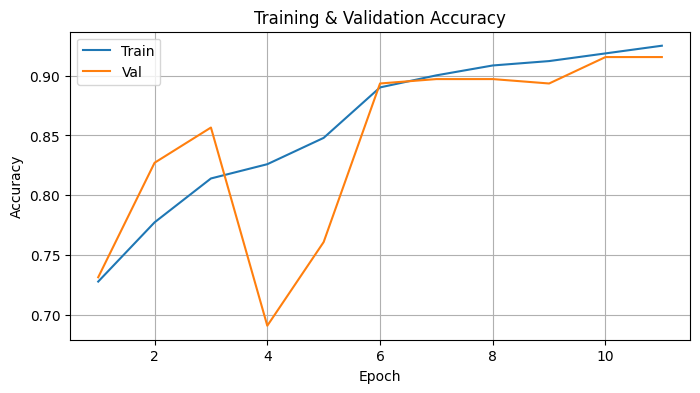

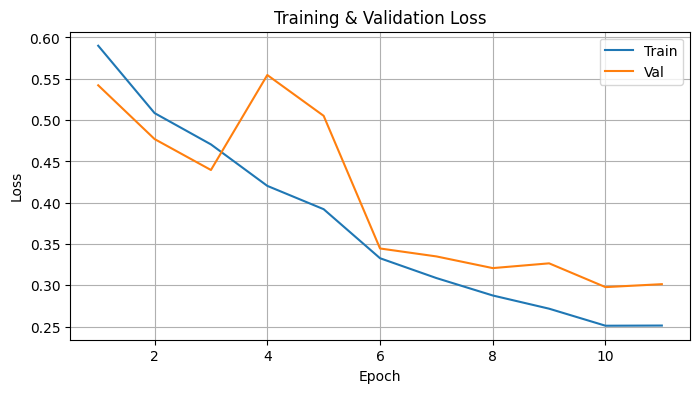

In [ ]:
# Notebook cell: Accuracy/Loss plots + Confusion Matrix + ROC + Metrics
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
from tensorflow.keras.utils import to_categorical

# --- 1) Select model reference ---
if 'model' in globals() and hasattr(globals()['model'], 'predict'):
    model_ref = globals()['model']
elif 'detector' in globals() and hasattr(detector, 'model'):
    model_ref = detector.model
else:
    raise RuntimeError("No model found in the notebook. Ensure `detector` or `model` exists.")

# --- 2) Plot training history (accuracy & loss) ---
hist = getattr(history, "history", history if isinstance(history, dict) else None)
if hist is None:
    raise RuntimeError("`history` not found or invalid. Ensure training produced a `history` object.")

def get_key(d, candidates):
    for c in candidates:
        if c in d:
            return c
    return None

acc_key = get_key(hist, ["video_pred_acc", "video_pred_accuracy", "acc", "accuracy"])
val_acc_key = get_key(hist, ["val_video_pred_acc", "val_video_pred_accuracy", "val_acc", "val_accuracy"])
loss_key = get_key(hist, ["loss"])
val_loss_key = get_key(hist, ["val_loss"])

epochs = range(1, (len(hist[loss_key]) if loss_key in hist else len(next(iter(hist.values()))) ) + 1)

if acc_key and val_acc_key:
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist[acc_key], label="Train")
    plt.plot(epochs, hist[val_acc_key], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Accuracy keys not found in history. Available keys:", list(hist.keys()))

if loss_key and val_loss_key:
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist[loss_key], label="Train")
    plt.plot(epochs, hist[val_loss_key], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Loss keys not found in history. Available keys:", list(hist.keys()))

# --- 3) Produce predictions on validation set robustly ---
if 'val_p' not in globals() or 'val_l' not in globals():
    raise RuntimeError("Validation data not available in notebook. Ensure `val_p` and `val_l` exist.")

val_paths = val_p
val_labels = np.array(val_l)
n_val = len(val_paths)
batch_for_eval = max(1, globals().get('BATCH_SIZE', 1))  # safe default
steps = max(1, math.ceil(n_val / batch_for_eval))

preds_batches = []

# If detector provides a batch generator, iterate it and call model.predict on each batch
if hasattr(detector, "dual_path_generator"):
    gen = detector.dual_path_generator(val_paths, val_labels.tolist(), batch_size=batch_for_eval, augment=False)
    for _ in range(steps):
        try:
            batch = next(gen)
        except StopIteration:
            break
        # batch can be (inputs, labels) or inputs only
        x = batch[0] if isinstance(batch, (list, tuple)) and len(batch) >= 1 else batch
        # call predict on the batch inputs (model will accept arrays / lists / dicts)
        preds_batches.append(model_ref.predict(x, verbose=0))
else:
    # fallback: try direct predict on val_paths (works if model accepts file paths or if val_p is an array)
    try:
        preds_raw_direct = model_ref.predict(val_paths, batch_size=batch_for_eval, verbose=1)
        preds_batches.append(preds_raw_direct)
    except Exception:
        # as final fallback, predict per-sample (slow but robust)
        for p in val_paths:
            try:
                # try to let model accept single sample input: first attempt detector helper if exists
                if hasattr(detector, "prepare_video_for_model"):
                    x_single = detector.prepare_video_for_model(p)
                    pred_single = model_ref.predict(np.expand_dims(x_single, axis=0), verbose=0)
                else:
                    # attempt model.predict on the path as single element list
                    pred_single = model_ref.predict([p], verbose=0)
                preds_batches.append(pred_single)
            except Exception as e:
                raise RuntimeError(f"Failed to predict for sample {p}: {e}")

# Aggregate batch-level predictions into preds_raw
if len(preds_batches) == 0:
    raise RuntimeError("No predictions were produced. Check the generator / model input format.")

first_pred = preds_batches[0]
if isinstance(first_pred, dict):
    # concatenate each dict entry across batches
    preds_raw = {}
    for k in first_pred.keys():
        try:
            preds_raw[k] = np.concatenate([batch[k] for batch in preds_batches], axis=0)
        except Exception:
            preds_raw[k] = np.vstack([np.atleast_2d(batch[k]) for batch in preds_batches])
else:
    try:
        preds_raw = np.concatenate(preds_batches, axis=0)
    except Exception:
        preds_raw = np.vstack([np.atleast_2d(b) for b in preds_batches])

# Extract y_score from preds_raw (support dict outputs like {"video_pred": ...})
if isinstance(preds_raw, dict):
    if "video_pred" in preds_raw:
        y_score = np.array(preds_raw["video_pred"])
    else:
        # use first available output
        first_key = next(iter(preds_raw.keys()))
        y_score = np.array(preds_raw[first_key])
else:
    y_score = np.array(preds_raw)

# Normalize shape and compute y_pred
if y_score.ndim == 1:
    y_score = y_score.reshape(-1, 1)
if y_score.shape[0] != n_val:
    # If length mismatch, truncate or pad appropriately (prefer truncation)
    y_score = y_score[:n_val]

if y_score.shape[1] == 1:
    y_pred = (y_score.ravel() >= 0.5).astype(int)
else:
    y_pred = np.argmax(y_score, axis=1)

y_true = val_labels

# --- 4) Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (validation)")
plt.show()

# --- 5) ROC Curve(s) & AUC ---
n_classes = y_score.shape[1] if y_score.ndim == 2 else 1
if n_classes == 1:
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (binary)")
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("Could not compute ROC for binary:", e)
else:
    # One-vs-rest ROC for each class
    y_true_onehot = to_categorical(y_true, num_classes=n_classes)
    plt.figure(figsize=(7,7))
    for i in range(n_classes):
        try:
            fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.3f})")
        except Exception as e:
            print(f"Could not compute ROC for class {i}: {e}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (one-vs-rest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# --- 6) Classification report & summary metrics ---
print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Weighted Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Attempt AUC summary
try:
    if n_classes == 1:
        auc_score = auc(*roc_curve(y_true, y_score.ravel())[:2])
        print(f"AUC (binary): {auc_score:.4f}")
    else:
        auc_macro = roc_auc_score = None
        try:
            from sklearn.metrics import roc_auc_score as _roc_auc_score
            y_true_onehot = to_categorical(y_true, num_classes=n_classes)
            auc_macro = _roc_auc_score(y_true_onehot, y_score, average="macro", multi_class="ovr")
            auc_weighted = _roc_auc_score(y_true_onehot, y_score, average="weighted", multi_class="ovr")
            print(f"AUC (macro): {auc_macro:.4f}")
            print(f"AUC (weighted): {auc_weighted:.4f}")
        except Exception:
            # ignore if not computable
            pass
except Exception as e:
    print("AUC computation failed:", e)

print("\nDone. The variables available for further analysis are: y_score, y_pred, y_true, cm, hist.")


In [ ]:
# === Post-training / evaluation cell ===
# Run this immediately after your training invocation:
# detector, history, (train_p, val_p, train_l, val_l) = run_training(...)

import os, shutil, json, csv, time
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Determine model checkpoint to use and Drive paths ---
# If you used the CopyToDriveCallback earlier, LOCAL_MODEL_PATH & DRIVE_MODEL_PATH may be set.
# Fall back to MODEL_PATH if needed.
LOCAL_MODEL_PATH = globals().get("LOCAL_MODEL_PATH", "/content/deepfake_t4_local.h5")
MODEL_PATH       = globals().get("MODEL_PATH", "/content/deepfake_t4.h5")
DRIVE_MODEL_PATH = "/content/drive/MyDrive/deepfake_t4.h5"
DRIVE_CACHE_DIR  = "/content/drive/MyDrive/deepfake_cache"

# If drive not mounted, mount it
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    # Not in Colab or already mounted — ignore
    pass

# Choose source checkpoint: prefer LOCAL_MODEL_PATH (fast), then MODEL_PATH
if os.path.exists(LOCAL_MODEL_PATH):
    src_ckpt = LOCAL_MODEL_PATH
elif os.path.exists(MODEL_PATH):
    src_ckpt = MODEL_PATH
else:
    # If detector.model was saved directly to a different path inside callbacks, try to find best .h5 in /content
    candidates = [p for p in ["/content/deepfake_t4.h5","/content/model.h5","/content/best_model.h5"] if os.path.exists(p)]
    src_ckpt = candidates[0] if candidates else None

print("Using checkpoint:", src_ckpt)

# Ensure Drive destination directory exists
os.makedirs(os.path.dirname(DRIVE_MODEL_PATH), exist_ok=True)
os.makedirs(DRIVE_CACHE_DIR, exist_ok=True)

# Copy to Drive (if available)
if src_ckpt and os.path.exists(src_ckpt):
    try:
        shutil.copy(src_ckpt, DRIVE_MODEL_PATH)
        print(f"Copied checkpoint to Drive: {DRIVE_MODEL_PATH}")
    except Exception as e:
        print("Warning: failed to copy checkpoint to Drive:", e)
else:
    print("Warning: no checkpoint file found to copy to Drive.")

# --- 2. Load checkpoint weights into detector.model (if not already loaded) ---
if src_ckpt and os.path.exists(src_ckpt):
    try:
        detector.model.load_weights(src_ckpt)
        print("Loaded weights from:", src_ckpt)
    except Exception as e:
        print("Could not load weights from checkpoint:", e)

# --- 3. Plot training history (loss & video accuracy if available) ---
try:
    h = history.history
    plt.figure(figsize=(10,4))
    # Loss plot
    plt.subplot(1,2,1)
    # possible keys: 'loss', 'val_loss' OR 'video_pred_loss', 'val_video_pred_loss' etc.
    if "loss" in h:
        plt.plot(h.get("loss",[]), label="train loss")
        plt.plot(h.get("val_loss",[]), label="val loss")
    else:
        # try top-level video_pred loss keys
        vloss = h.get("video_pred_loss", h.get("loss", []))
        vvall  = h.get("val_video_pred_loss", h.get("val_loss", []))
        if len(vloss)>0:
            plt.plot(vloss, label="train video loss")
            plt.plot(vvall, label="val video loss")
    plt.legend(); plt.title("Loss")

    # Accuracy plot
    plt.subplot(1,2,2)
    # metric name may be 'video_pred_acc' or 'video_pred_binary_accuracy' or similar
    acc_keys = [k for k in h.keys() if "video_pred" in k and "acc" in k or k.endswith("acc")]
    if acc_keys:
        for k in acc_keys:
            plt.plot(h[k], label=k)
        # val variants
        val_keys = [k for k in h.keys() if k.startswith("val_") and ("video_pred" in k or k.endswith("acc"))]
        for k in val_keys:
            plt.plot(h[k], label=k)
    else:
        # fallback: try 'acc' and 'val_acc'
        if "video_pred_acc" in h or "val_video_pred_acc" in h:
            plt.plot(h.get("video_pred_acc", []), label="train acc")
            plt.plot(h.get("val_video_pred_acc", []), label="val acc")
    plt.legend(); plt.title("Accuracy / Metrics")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot history:", e)

# --- 4. Run predictions on the validation set and compute metrics ---
print("\nRunning predictions on validation set (this may take a while)...")
y_true = []
y_scores = []
video_paths = []

for vp, true_lbl in zip(val_p, val_l):
    try:
        score, _ = predict_video(detector, vp)   # uses detector.model weights loaded above
        y_true.append(int(true_lbl))
        y_scores.append(float(score))
        video_paths.append(vp)
    except Exception as e:
        # If a particular video fails, print and skip
        print("Skipping", vp, "-> error:", e)

print(f"Predicted {len(y_scores)} / {len(val_p)} validation videos.")

# --- 5. Compute metrics and confusion matrix ---
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

preds = [1 if s >= 0.5 else 0 for s in y_scores]
acc = accuracy_score(y_true, preds) if len(y_true)>0 else float("nan")
auc = roc_auc_score(y_true, y_scores) if len(set(y_true))>1 else float("nan")
cm = confusion_matrix(y_true, preds).tolist() if len(y_true)>0 else None

print("\nValidation metrics:")
print(" Accuracy:", acc)
print(" AUC:", auc)
print(" Confusion matrix:", cm)

# --- 6. Save evaluation outputs to Drive (JSON + CSV) ---
eval_summary = {"accuracy": float(acc) if acc is not None else None,
                "auc": float(auc) if auc is not None else None,
                "confusion_matrix": cm}

EVAL_JSON = "/content/drive/MyDrive/deepfake_eval_summary.json"
EVAL_CSV  = "/content/drive/MyDrive/deepfake_eval_per_video.csv"
os.makedirs(os.path.dirname(EVAL_JSON), exist_ok=True)

with open(EVAL_JSON, "w") as f:
    json.dump(eval_summary, f)
print("Saved eval summary JSON to", EVAL_JSON)

with open(EVAL_CSV, "w", newline="") as cf:
    writer = csv.writer(cf)
    writer.writerow(["video_path", "true_label", "score", "pred_label"])
    for vp, t, s, p in zip(video_paths, y_true, y_scores, preds):
        writer.writerow([vp, int(t), float(s), int(p)])
print("Saved per-video CSV to", EVAL_CSV)

# --- 7. Show a few example predictions (first 6) ---
print("\nSample predictions:")
for vp, t, s in list(zip(video_paths, y_true, y_scores))[:6]:
    print(os.path.basename(vp), "| true:", t, "| score(real=1):", f"{s:.4f}", "| pred:", int(s>=0.5))

# --- 8. (Optional) copy final checkpoint again to a timestamped path on Drive ---
try:
    if src_ckpt and os.path.exists(src_ckpt):
        stamp = time.strftime("%Y%m%d-%H%M%S")
        dst = f"/content/drive/MyDrive/deepfake_t4_{stamp}.h5"
        shutil.copy(src_ckpt, dst)
        print("Also copied checkpoint to", dst)
except Exception as e:
    print("Could not copy timestamped checkpoint:", e)

print("\nPost-training evaluation complete.")


In [ ]:
# === Training cell ===
# Paste & run this after you've defined all classes/functions (run_training, predict_video, evaluate_on_dataset)

import time, json, csv
from pathlib import Path

# Config
DATA_ROOT = "/content/deepfake_dataset"
EPOCHS = 10         # set to 10 (or 8/you choose)
BATCH_SIZE = 2
RESUME = True       # resume from existing checkpoint if present
SAVE_EVAL_JSON = "/content/eval_results.json"
SAVE_EVAL_CSV  = "/content/eval_per_video.csv"

print("Starting training run")
print("DATA_ROOT:", DATA_ROOT, "EPOCHS:", EPOCHS, "BATCH_SIZE:", BATCH_SIZE, "RESUME:", RESUME)

start_time = time.time()

# Run training (returns detector, history, (train_p, val_p, train_l, val_l))
detector, history, (train_p, val_p, train_l, val_l) = run_training(
    base_dir=DATA_ROOT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    resume=RESUME
)

print(f"Training finished in {(time.time() - start_time)/60:.2f} minutes")
print("Best model saved at:", MODEL_PATH)

# Optional: quick history plot (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    if hasattr(history, "history"):
        h = history.history
        plt.figure(figsize=(10,4))
        if "loss" in h:
            plt.subplot(1,2,1); plt.plot(h.get("loss",[]), label="train loss"); plt.plot(h.get("val_loss",[]), label="val loss"); plt.legend(); plt.title("Loss")
        if "video_pred_acc" in h or "val_video_pred_acc" in h:
            plt.subplot(1,2,2); plt.plot(h.get("video_pred_acc", []), label="train acc"); plt.plot(h.get("val_video_pred_acc", []), label="val acc"); plt.legend(); plt.title("Video Acc")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Plotting skipped (matplotlib missing or error):", e)

# Evaluate on validation set using existing helper (will print per-video results)
print("\nRunning evaluation on validation samples...")
eval_results = {}
try:
    # evaluate_on_dataset will call predict_video internally and print summary
    results = evaluate_on_dataset(detector, DATA_ROOT, num_samples=6)
    # Convert to simpler metrics if possible
    y_true = [r[1] for r in results]
    y_scores = [r[2] for r in results]
    from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
    preds = [1 if s>=0.5 else 0 for s in y_scores]
    acc = accuracy_score(y_true, preds) if len(y_true)>0 else float("nan")
    auc = roc_auc_score(y_true, y_scores) if len(set(y_true))>1 else float("nan")
    cm = confusion_matrix(y_true, preds).tolist() if len(y_true)>0 else None
    eval_results = {"accuracy": acc, "auc": auc, "confusion_matrix": cm, "y_scores": y_scores, "video_paths":[r[0] for r in results], "y_true": y_true}
except Exception as e:
    print("evaluate_on_dataset failed:", e)
    # fallback: run prediction across validation set (may be slower)
    y_true, y_scores, vpaths = [], [], []
    for vp, lbl in zip(val_p, val_l):
        try:
            score, _ = predict_video(detector, vp)
            y_true.append(int(lbl)); y_scores.append(float(score)); vpaths.append(vp)
        except Exception as ex:
            print("Skipping", vp, "due to error:", ex)
    try:
        from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
        preds = [1 if s>=0.5 else 0 for s in y_scores]
        acc = accuracy_score(y_true, preds) if len(y_true)>0 else float("nan")
        auc = roc_auc_score(y_true, y_scores) if len(set(y_true))>1 else float("nan")
        cm = confusion_matrix(y_true, preds).tolist() if len(y_true)>0 else None
        eval_results = {"accuracy": acc, "auc": auc, "confusion_matrix": cm, "y_scores": y_scores, "video_paths": vpaths, "y_true": y_true}
    except Exception as e2:
        print("Could not compute sklearn metrics:", e2)
        eval_results = {"accuracy": None, "auc": None, "confusion_matrix": None, "y_scores": y_scores, "video_paths": vpaths, "y_true": y_true}

# Save evaluation summary JSON
summary = {"accuracy": float(eval_results["accuracy"]) if eval_results.get("accuracy") is not None else None,
           "auc": float(eval_results["auc"]) if eval_results.get("auc") is not None else None,
           "confusion_matrix": eval_results.get("confusion_matrix")}
with open(SAVE_EVAL_JSON, "w") as f:
    json.dump(summary, f)
print("Saved evaluation summary to", SAVE_EVAL_JSON)

# Save per-video CSV
with open(SAVE_EVAL_CSV, "w", newline="") as csvf:
    writer = csv.writer(csvf)
    writer.writerow(["video_path","true_label","score","pred_label"])
    for vp, lbl, score in zip(eval_results.get("video_paths", []), eval_results.get("y_true", []), eval_results.get("y_scores", [])):
        writer.writerow([vp, int(lbl), float(score), int(score >= 0.5)])
print("Saved per-video results to", SAVE_EVAL_CSV)

print("\nDone.")



Starting training run
DATA_ROOT: /content/deepfake_dataset EPOCHS: 10 BATCH_SIZE: 2 RESUME: True
Found 363 real videos, 1002 fake videos

[Warmup] Caching 1092 train videos ...
  Cached 50/1092 videos
  Cached 100/1092 videos
  Cached 150/1092 videos
  Cached 200/1092 videos
  Cached 250/1092 videos
  Cached 300/1092 videos
  Cached 350/1092 videos
  Cached 400/1092 videos
  Cached 450/1092 videos
  Cached 500/1092 videos
  Cached 550/1092 videos
  Cached 600/1092 videos
  Cached 650/1092 videos
  Cached 700/1092 videos
  Cached 750/1092 videos
  Cached 800/1092 videos
  Cached 850/1092 videos
  Cached 900/1092 videos
  Cached 950/1092 videos
  Cached 1000/1092 videos
  Cached 1050/1092 videos
[Warmup] Done caching train


[Warmup] Caching 273 val videos ...
  Cached 50/273 videos
  Cached 100/273 videos
  Cached 150/273 videos
  Cached 200/273 videos
  Cached 250/273 videos
[Warmup] Done caching val

Epoch 1/10


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was ((tf.float32, tf.float32, tf.float32), {'video_pred': tf.float32, 'frame_logits': tf.float32}), but the yielded element was ([array([[[[[ 32.,  39.,  51.],
          [ 31.,  38.,  50.],
          [ 32.,  36.,  49.],
          ...,
          [ 43.,  38.,  37.],
          [ 31.,  29.,  32.],
          [ 34.,  33.,  36.]],

         [[ 32.,  39.,  51.],
          [ 31.,  38.,  50.],
          [ 32.,  36.,  49.],
          ...,
          [ 41.,  36.,  35.],
          [ 29.,  28.,  31.],
          [ 43.,  42.,  45.]],

         [[ 34.,  39.,  49.],
          [ 32.,  37.,  47.],
          [ 32.,  37.,  47.],
          ...,
          [ 32.,  30.,  32.],
          [ 31.,  29.,  33.],
          [ 39.,  38.,  42.]],

         ...,

         [[107., 110., 121.],
          [107., 110., 121.],
          [107., 110., 121.],
          ...,
          [  3.,  21.,  20.],
          [  3.,  28.,  25.],
          [  3.,  27.,  24.]],

         [[107., 110., 121.],
          [107., 110., 121.],
          [107., 110., 121.],
          ...,
          [  0.,  14.,  14.],
          [  0.,  26.,  26.],
          [  2.,  29.,  26.]],

         [[107., 110., 121.],
          [107., 110., 121.],
          [107., 110., 121.],
          ...,
          [  1.,  22.,  20.],
          [  4.,  32.,  26.],
          [  6.,  34.,  30.]]],


        [[[ 34.,  38.,  51.],
          [ 32.,  37.,  47.],
          [ 29.,  36.,  48.],
          ...,
          [ 83.,  80.,  86.],
          [ 90.,  89.,  92.],
          [ 92.,  91.,  94.]],

         [[ 38.,  42.,  55.],
          [ 32.,  37.,  47.],
          [ 29.,  36.,  48.],
          ...,
          [ 49.,  46.,  52.],
          [ 51.,  51.,  51.],
          [ 53.,  53.,  53.]],

         [[ 37.,  41.,  54.],
          [ 32.,  37.,  47.],
          [ 31.,  36.,  46.],
          ...,
          [ 36.,  33.,  39.],
          [ 43.,  42.,  45.],
          [ 41.,  40.,  43.]],

         ...,

         [[106., 109., 120.],
          [106., 109., 120.],
          [106., 109., 120.],
          ...,
          [  2.,  32.,  25.],
          [  1.,  27.,  21.],
          [  2.,  27.,  16.]],

         [[106., 109., 120.],
          [106., 109., 120.],
          [106., 109., 120.],
          ...,
          [  6.,  37.,  27.],
          [  8.,  37.,  25.],
          [  4.,  30.,  17.]],

         [[106., 109., 120.],
          [106., 109., 120.],
          [106., 109., 120.],
          ...,
          [ 12.,  43.,  30.],
          [ 24.,  54.,  33.],
          [ 11.,  39.,  21.]]],


        [[[ 33.,  37.,  50.],
          [ 31.,  35.,  48.],
          [ 27.,  34.,  46.],
          ...,
          [ 37.,  35.,  36.],
          [ 29.,  28.,  31.],
          [ 32.,  29.,  35.]],

         [[ 33.,  37.,  50.],
          [ 31.,  35.,  48.],
          [ 27.,  34.,  46.],
          ...,
          [ 39.,  37.,  38.],
          [ 27.,  26.,  28.],
          [ 44.,  41.,  47.]],

         [[ 32.,  37.,  47.],
          [ 29.,  34.,  44.],
          [ 31.,  36.,  46.],
          ...,
          [ 30.,  28.,  33.],
          [ 29.,  30.,  34.],
          [ 37.,  37.,  42.]],

         ...,

         [[106., 109., 120.],
          [106., 109., 120.],
          [106., 109., 120.],
          ...,
          [  4.,  18.,  21.],
          [  3.,  28.,  26.],
          [  4.,  28.,  25.]],

         [[106., 109., 120.],
          [106., 109., 120.],
          [105., 107., 121.],
          ...,
          [  0.,  12.,  13.],
          [  1.,  26.,  23.],
          [  3.,  29.,  28.]],

         [[106., 109., 120.],
          [106., 109., 120.],
          [105., 107., 121.],
          ...,
          [  3.,  19.,  19.],
          [  6.,  31.,  28.],
          [  9.,  36.,  32.]]],


        [[[ 32.,  36.,  49.],
          [ 31.,  35.,  48.],
          [ 29.,  36.,  48.],
          ...,
          [ 38.,  33.,  35.],
          [ 27.,  27.,  27.],
          [ 31.,  29.,  37.]],

         [[ 32.,  36.,  49.],
          [ 31.,  35.,  48.],
          [ 29.,  36.,  48.],
          ...,
          [ 41.,  36.,  38.],
          [ 28.,  27.,  32.],
          [ 41.,  39.,  47.]],

         [[ 32.,  37.,  47.],
          [ 29.,  34.,  44.],
          [ 31.,  36.,  46.],
          ...,
          [ 29.,  28.,  33.],
          [ 29.,  29.,  34.],
          [ 38.,  37.,  42.]],

         ...,

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  4.,  19.,  19.],
          [  3.,  28.,  26.],
          [  1.,  25.,  25.]],

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  0.,  12.,  11.],
          [  1.,  25.,  25.],
          [  4.,  28.,  25.]],

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  3.,  19.,  17.],
          [  2.,  32.,  27.],
          [  8.,  37.,  30.]]],


        [[[ 30.,  37.,  49.],
          [ 29.,  36.,  48.],
          [ 29.,  33.,  46.],
          ...,
          [ 39.,  37.,  38.],
          [ 30.,  29.,  32.],
          [ 29.,  30.,  35.]],

         [[ 30.,  37.,  49.],
          [ 29.,  36.,  48.],
          [ 31.,  35.,  48.],
          ...,
          [ 39.,  37.,  38.],
          [ 25.,  24.,  29.],
          [ 41.,  42.,  47.]],

         [[ 32.,  37.,  47.],
          [ 28.,  33.,  43.],
          [ 31.,  35.,  48.],
          ...,
          [ 29.,  29.,  29.],
          [ 30.,  28.,  31.],
          [ 38.,  37.,  42.]],

         ...,

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  2.,  17.,  17.],
          [  2.,  27.,  24.],
          [  1.,  28.,  25.]],

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  0.,  13.,  14.],
          [  0.,  25.,  22.],
          [  5.,  30.,  27.]],

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [  2.,  20.,  19.],
          [  3.,  32.,  26.],
          [  9.,  36.,  32.]]],


        [[[ 33.,  37.,  52.],
          [ 32.,  36.,  49.],
          [ 29.,  36.,  48.],
          ...,
          [  1.,   0.,   7.],
          [  1.,   0.,   7.],
          [  1.,   0.,   7.]],

         [[ 33.,  37.,  52.],
          [ 31.,  35.,  48.],
          [ 30.,  37.,  49.],
          ...,
          [  1.,   0.,   7.],
          [  1.,   0.,   7.],
          [  1.,   0.,   7.]],

         [[ 33.,  38.,  48.],
          [ 31.,  36.,  46.],
          [ 32.,  37.,  47.],
          ...,
          [  0.,   0.,   4.],
          [  1.,   0.,   5.],
          [  1.,   0.,   5.]],

         ...,

         [[105., 108., 119.],
          [105., 108., 119.],
          [105., 108., 119.],
          ...,
          [152., 111., 122.],
          [164., 123., 137.],
          [152., 115., 130.]],

         [[105., 107., 121.],
          [105., 107., 121.],
          [105., 107., 121.],
          ...,
          [153., 114., 125.],
          [159., 122., 138.],
          [140., 105., 120.]],

         [[105., 107., 121.],
          [105., 107., 121.],
          [105., 107., 121.],
          ...,
          [148., 112., 122.],
          [149., 113., 123.],
          [132.,  98., 110.]]]],



       [[[[ 30.,  25.,  22.],
          [ 25.,  20.,  17.],
          [ 35.,  30.,  27.],
          ...,
          [ 14.,   9.,  11.],
          [ 27.,  22.,  24.],
          [ 55.,  50.,  52.]],

         [[111., 106., 103.],
          [166., 162., 159.],
          [153., 148., 145.],
          ...,
          [111., 109., 110.],
          [119., 117., 118.],
          [115., 113., 114.]],

         [[ 99.,  94.,  91.],
          [ 57.,  52.,  49.],
          [ 49.,  44.,  41.],
          ...,
          [ 62.,  62.,  59.],
          [ 47.,  47.,  44.],
          [ 29.,  29.,  26.]],

         ...,

         [[199., 206., 199.],
          [201. [Op:__inference_multi_step_on_iterator_414719]

In [ ]:
if __name__ == "__main__":
    EPOCHS = 8
    BATCH_SIZE = 2
    detector, history, (train_p, val_p, train_l, val_l) = run_training(base_dir=DATA_ROOT, epochs=EPOCHS, batch_size=BATCH_SIZE, resume=True)
    plot_history(history)
    eval_results = evaluate_on_validation(detector, val_p, val_l, plot_figures=True)
    # Save outputs
    eval_summary = {"accuracy": float(eval_results["accuracy"]), "auc": float(eval_results["auc"]), "confusion_matrix": eval_results["confusion_matrix"].tolist()}
    with open("/content/eval_results.json", "w") as f:
        json.dump(eval_summary, f)
    import csv
    with open("/content/eval_per_video.csv", "w", newline="") as csvf:
        writer = csv.writer(csvf)
        writer.writerow(["video_path","true_label","score","pred_label"])
        for vp, lbl, score in zip(val_p, val_l, eval_results["y_scores"]):
            writer.writerow([vp, int(lbl), float(score), int(score>=0.5)])
    print("Saved evaluation summary to /content/eval_results.json and /content/eval_per_video.csv")
    print("Done.")

Found 363 real videos, 1002 fake videos
Warmup cache (this will process videos and can take time)...

[Warmup] Caching 1092 train videos ...
  Cached 50/1092 videos
  Cached 100/1092 videos
  Cached 150/1092 videos
  Cached 200/1092 videos
  Cached 250/1092 videos
  Cached 300/1092 videos
  Cached 350/1092 videos
  Cached 400/1092 videos
  Cached 450/1092 videos
  Cached 500/1092 videos
  Cached 550/1092 videos
  Cached 600/1092 videos
  Cached 650/1092 videos
  Cached 700/1092 videos
  Cached 750/1092 videos
  Cached 800/1092 videos
  Cached 850/1092 videos
  Cached 900/1092 videos
  Cached 950/1092 videos
  Cached 1000/1092 videos
  Cached 1050/1092 videos
[Warmup] Done caching train


[Warmup] Caching 273 val videos ...
  Cached 50/273 videos
  Cached 100/273 videos
  Cached 150/273 videos
  Cached 200/273 videos
  Cached 250/273 videos
[Warmup] Done caching val

Using class weights: {'video_pred': {0: 0.6807980049875312, 1: 1.8827586206896552}}


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'workers'

In [ ]:
# === ALL-IN-ONE Colab cell: install, restart if needed, mount, extract, train, evaluate ===
import os, sys, time, math, glob, shutil, zipfile, random, hashlib, pickle
from pathlib import Path

SETUP_FLAG = "/content/.colab_setup_done"

# -------------------------------
# 1) Attempt imports; if they fail, install compatible packages and restart the runtime.
# -------------------------------
def ensure_env():
    try:
        import importlib
        import numpy as np
        import cv2
        import tensorflow as tf
        import sklearn
        import matplotlib
        # If we reach here, assume good environment.
        return True
    except Exception as e:
        print("Detected missing/incompatible packages or import error:", repr(e))
        print("Installing compatible numpy and opencv + supporting libs. Runtime will restart.")
        # Uninstall/Install compatible versions commonly working in Colab
        # (This cell will kill the runtime below; re-run the same cell after restart to continue.)
        os.system("pip uninstall -y opencv-python opencv-python-headless >/dev/null 2>&1 || true")
        os.system("pip install -q --upgrade pip")
        # Choose numpy compatible with many TF & OpenCV wheels; adjust if TF version later indicates mismatch.
        os.system("pip install -q numpy==1.25.2")
        os.system("pip install -q opencv-python-headless==4.7.0.72 scikit-learn matplotlib imageio-ffmpeg tqdm")
        # After install, create flag so that after restart we don't reinstall repeatedly
        Path(SETUP_FLAG).write_text("installed\n")
        # Restart runtime
        print("Packages installed. Restarting runtime now to load native extensions...")
        os.kill(os.getpid(), 9)

# If not already setup, try to ensure environment
if not os.path.exists(SETUP_FLAG):
    ensure_env()

# After a restart, or if setup already done, proceed
# -------------------------------
# 2) Now safe imports and seeding
# -------------------------------
import numpy as np, cv2
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, callbacks
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB4
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import itertools
import json

# reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mixed precision: enable if GPU and TF supports it
try:
    if tf.config.list_physical_devices('GPU'):
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled (mixed_float16).")
except Exception as e:
    print("Mixed precision not enabled:", e)

# -------------------------------
# 3) Paths and Drive extraction
# -------------------------------
CACHE_DIR = "/content/deepfake_cache"
MODEL_PATH = "/content/deepfake_t4.h5"
DATA_ROOT = "/content/deepfake_dataset"
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(DATA_ROOT, exist_ok=True)

# Mount Drive if available (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DRIVE_ROOT = "/content/drive/MyDrive"
    print("Google Drive mounted.")
except Exception as e:
    DRIVE_ROOT = None
    print("Google Drive mount skipped or not available:", e)

def find_and_extract(zip_name, target_subdir):
    target_dir = os.path.join(DATA_ROOT, target_subdir)
    os.makedirs(target_dir, exist_ok=True)
    search_roots = []
    if DRIVE_ROOT and os.path.exists(DRIVE_ROOT):
        search_roots.append(DRIVE_ROOT)
    search_roots.append(os.getcwd())
    found = False
    for root in search_roots:
        for path, dirs, files in os.walk(root):
            if zip_name in files:
                zip_path = os.path.join(path, zip_name)
                print(f"Found {zip_name} at {zip_path}. Extracting .mp4 files to {target_dir} ...")
                try:
                    with zipfile.ZipFile(zip_path, 'r') as z:
                        for member in z.namelist():
                            if member.lower().endswith('.mp4'):
                                member_name = os.path.basename(member)
                                if not member_name:
                                    continue
                                dest = os.path.join(target_dir, member_name)
                                with z.open(member) as source, open(dest, "wb") as destf:
                                    shutil.copyfileobj(source, destf)
                    found = True
                except zipfile.BadZipFile:
                    print(f"Error: {zip_path} is not a valid zip file.")
                break
        if found:
            break
    if not found:
        print(f"Warning: {zip_name} not found under {search_roots}. Please upload or place the zip in Drive/MyDrive or /content.")
    return found

# Attempt extraction (r.zip -> real/real ; f.zip -> fake/fakes)
find_and_extract("r.zip", "real/real")
find_and_extract("f.zip", "fake/fakes")

# Show counts
real_count = len(glob.glob(os.path.join(DATA_ROOT, "real","real","*.mp4")))
fake_count = len(glob.glob(os.path.join(DATA_ROOT, "fake","fakes","*.mp4")))
print(f"Dataset counts after extraction: real={real_count}, fake={fake_count}")

if real_count + fake_count == 0:
    print("No videos found for training. Please ensure r.zip and f.zip exist and contain .mp4 files in Drive or upload them.")
    # Exit gracefully - nothing further to run
    raise SystemExit("No dataset available.")

# -------------------------------
# 4) Detector class (kept original logic; small defensive fixes)
# -------------------------------
class PatentAlignedDeepfakeDetector:
    def __init__(self, max_frames=6, resize_to=(224,224), ascii_grid=(80,40),
                 ascii_stats_dim=32, cache_dir=CACHE_DIR):
        self.max_frames = max_frames
        self.resize_to = resize_to
        self.ascii_grid = ascii_grid
        self.ascii_stats_dim = ascii_stats_dim
        self.ASCII_CHARS = "@%#*+=-:. "
        self.intensity_bins = np.linspace(0, 255, len(self.ASCII_CHARS))
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _cache_key(self, video_path):
        return os.path.join(self.cache_dir, hashlib.md5(video_path.encode()).hexdigest()+".pkl")

    def vectorized_ascii_conversion(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        H, W = gray.shape
        gh, gw = self.ascii_grid
        if gh <= 0 or gw <= 0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        crop_h, crop_w = (H//gh)*gh, (W//gw)*gw
        gray = gray[:crop_h,:crop_w] if crop_h>0 and crop_w>0 else gray
        if crop_h==0 or crop_w==0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        cell_h, cell_w = crop_h//gh, crop_w//gw
        try:
            cells = gray.reshape(gh,cell_h,gw,cell_w)
            means = cells.mean(axis=(1,3))
            ascii_idx = np.digitize(means, self.intensity_bins)-1
            ascii_idx = np.clip(ascii_idx, 0, len(self.ASCII_CHARS)-1)
            ascii_vals = np.array([ord(self.ASCII_CHARS[i]) for i in ascii_idx.flatten()]).reshape(ascii_idx.shape)
            ascii_img = np.stack([ascii_vals]*3,axis=-1).astype(np.float32)
            return cv2.resize(ascii_img, self.resize_to)
        except Exception:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)

    def compute_ascii_stats(self, ascii_frames):
        ent = []
        for f in ascii_frames:
            flat = f[:,:,0].flatten()
            if len(flat)<3:
                ent.append((0.0,0.0))
                continue
            ent.append((float(np.std(flat)), float(np.mean(flat))))
        if len(ent)==0:
            packed = np.array([0.0,0.0])
        else:
            packed = np.mean(ent,axis=0)
        reps = int(np.ceil(self.ascii_stats_dim/packed.size))
        return np.tile(packed,reps)[:self.ascii_stats_dim].astype(np.float32)

    def extract_frames_dual_path(self, video_path):
        cache_file = self._cache_key(video_path)
        if os.path.exists(cache_file):
            try:
                return pickle.load(open(cache_file,"rb"))
            except Exception:
                pass

        cap = cv2.VideoCapture(video_path)
        pixel, ascii_ = [], []
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if total > self.max_frames:
            idxs = np.linspace(0, total-1, self.max_frames, dtype=int)
        elif total > 0:
            idxs = range(0, min(total, self.max_frames))
        else:
            idxs = []
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, f = cap.read()
            if not ret:
                continue
            f = cv2.resize(f, self.resize_to)[:,:,::-1]
            pixel.append(f)
            ascii_.append(self.vectorized_ascii_conversion(f))
        cap.release()
        while len(pixel) < self.max_frames:
            if pixel:
                pixel.append(pixel[-1].copy())
                ascii_.append(ascii_[-1].copy())
            else:
                pixel.append(np.zeros((*self.resize_to,3), np.uint8))
                ascii_.append(np.zeros((*self.resize_to,3), np.uint8))
        pixel = np.stack(pixel).astype(np.float32)
        ascii_ = np.stack(ascii_).astype(np.float32)
        stats = self.compute_ascii_stats(ascii_)
        data = (pixel, ascii_, stats)
        try:
            pickle.dump(data, open(cache_file, "wb"))
        except Exception:
            pass
        return data

    def build_patent_aligned_model(self):
        T, H, W = self.max_frames, *self.resize_to
        pix_in = Input((T,H,W,3), name="pixel_input")
        asc_in = Input((T,H,W,3), name="ascii_input")
        stats_in = Input((self.ascii_stats_dim,), name="ascii_stats_input")

        irv2 = InceptionResNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        effb4 = EfficientNetB4(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        irv2.trainable = False
        effb4.trainable = False

        pix = layers.TimeDistributed(layers.Lambda(lambda x: irv2(irv2_preprocess(x))))(pix_in)
        asc = layers.TimeDistributed(layers.Lambda(lambda x: effb4(eff_preprocess(x))))(asc_in)
        stats = layers.RepeatVector(T)(layers.Dense(32, activation="relu")(stats_in))
        fused = layers.Concatenate()([pix, asc, stats])

        temporal = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(fused)
        frame_logits = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="frame_logits")(temporal)
        video_pred = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name="video_pred")(frame_logits)

        self.model = Model([pix_in, asc_in, stats_in], [video_pred, frame_logits])
        return self.model

    def _temporal_penalty_loss(self, y_true, frame_logits):
        diffs = frame_logits[:,1:,:] - frame_logits[:,:-1,:]
        return tf.reduce_mean(tf.abs(diffs))

    def compile_model(self, lr=1e-4, temporal_loss_weight=0.1):
        bce = tf.keras.losses.BinaryCrossentropy()
        def vloss(y_true, y_pred): return bce(y_true, y_pred)
        def tloss(y_true, y_pred): return self._temporal_penalty_loss(y_true, y_pred)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss={"video_pred": vloss, "frame_logits": tloss},
            loss_weights={"video_pred": 1.0, "frame_logits": temporal_loss_weight},
            metrics={"video_pred": [tf.keras.metrics.BinaryAccuracy(name="acc")]}
        )

    def dual_path_generator(self, paths, labels, batch_size=2, augment=False):
        while True:
            data = list(zip(paths, labels)); random.shuffle(data)
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                Xp, Xa, Xs, Y = [], [], [], []
                for vp, lbl in batch:
                    pf, af, st = self.extract_frames_dual_path(vp)
                    if augment and random.random() > 0.5:
                        pf, af = pf[:, ::-1, :, :], af[:, ::-1, :, :]
                    Xp.append(pf.astype("float32"))
                    Xa.append(af.astype("float32"))
                    Xs.append(st.astype("float32"))
                    Y.append(lbl)
                Xp = np.stack(Xp)
                Xa = np.stack(Xa)
                Xs = np.stack(Xs)
                Yv = np.array(Y, dtype=np.float32).reshape(-1,1)
                Yf = np.zeros((len(Y), self.max_frames, 1), dtype=np.float32)
                yield [Xp, Xa, Xs], {"video_pred": Yv, "frame_logits": Yf}

# -------------------------------
# 5) Dataset loader and helpers
# -------------------------------
def load_dataset(base_dir=DATA_ROOT, test_size=0.2):
    real_dir = os.path.join(base_dir, "real", "real")
    fake_dir = os.path.join(base_dir, "fake", "fakes")
    real = sorted(glob.glob(os.path.join(real_dir, "*.mp4")))
    fake = sorted(glob.glob(os.path.join(fake_dir, "*.mp4")))
    print(f"Found {len(real)} real videos, {len(fake)} fake videos")
    if len(real) + len(fake) == 0:
        raise FileNotFoundError("No mp4 files found.")
    paths = real + fake
    labels = [1]*len(real) + [0]*len(fake)
    strat = labels if len(set(labels))>1 else None
    return train_test_split(paths, labels, test_size=test_size, stratify=strat, random_state=SEED)

def warmup_cache(detector, paths, label="train"):
    print(f"\n[Warmup] Caching {len(paths)} {label} videos ...")
    for idx, vp in enumerate(paths):
        try:
            _ = detector.extract_frames_dual_path(vp)
        except Exception as e:
            print(f"[WARN] Failed caching {vp}: {e}")
        if (idx + 1) % 50 == 0:
            print(f"  Cached {idx+1}/{len(paths)} videos")
    print(f"[Warmup] Done caching {label} set (stored in {detector.cache_dir})\n")

# -------------------------------
# 6) Training, evaluation and plotting
# -------------------------------
def plot_history(history):
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if "loss" in hist:
        plt.plot(hist["loss"], label="train_total_loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_total_loss")
    if "video_pred_loss" in hist:
        plt.plot(hist["video_pred_loss"], label="train_video_loss")
    if "val_video_pred_loss" in hist:
        plt.plot(hist["val_video_pred_loss"], label="val_video_loss")
    plt.title("Losses")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    if "video_pred_acc" in hist:
        plt.plot(hist["video_pred_acc"], label="train_video_acc")
    if "val_video_pred_acc" in hist:
        plt.plot(hist["val_video_pred_acc"], label="val_video_acc")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_single(detector, video_path):
    pixel_frames, ascii_frames, stats = detector.extract_frames_dual_path(video_path)
    Xp = np.expand_dims(pixel_frames.astype("float32"), 0)
    Xa = np.expand_dims(ascii_frames.astype("float32"), 0)
    Xs = np.expand_dims(stats.astype("float32"), 0)
    preds = detector.model.predict([Xp, Xa, Xs], verbose=0)
    video_pred, frame_preds = preds
    video_score = float(video_pred[0][0])
    frame_scores = frame_preds[0,:,0]
    return video_score, frame_scores

def evaluate_on_validation(detector, val_paths, val_labels, plot_figures=True):
    y_true, y_scores = [], []
    for vp, lbl in zip(val_paths, val_labels):
        try:
            score, _ = predict_single(detector, vp)
        except Exception as e:
            print(f"[WARN] predict failed for {vp}: {e}")
            score = 0.5
        y_true.append(lbl)
        y_scores.append(score)
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = (y_scores >= 0.5).astype(int)
    try:
        auc_score = roc_auc_score(y_true, y_scores)
    except Exception:
        auc_score = float('nan')
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    acc = (y_pred == y_true).mean()
    print("\n=== Evaluation on validation set ===")
    print(f"Samples: {len(y_true)}  Accuracy: {acc:.4f}  AUC: {auc_score:.4f}")
    print("\nClassification report:\n", cr)
    print("\nConfusion matrix:\n", cm)
    if plot_figures:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc_val = auc(fpr, tpr)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
            plt.plot([0,1],[0,1],"--")
            plt.title("ROC curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print("ROC plot failed:", e)
        plt.figure(figsize=(5,4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["fake(0)","real(1)"])
        plt.yticks(tick_marks, ["fake(0)","real(1)"])
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    return {"accuracy": acc, "auc": auc_score, "confusion_matrix": cm, "report": cr, "y_true": y_true, "y_scores": y_scores}

# -------------------------------
# 7) Main training entry
# -------------------------------
def run_training(base_dir=DATA_ROOT, epochs=8, batch_size=2, resume=True):
    train_p, val_p, train_l, val_l = load_dataset(base_dir)
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    det_model = det.build_patent_aligned_model()
    det.compile_model()

    # Warmup cache (comment out if dataset very large)
    print("Starting cache warmup. This may take some time depending on dataset size.")
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p, label="val")

    # Compute class weights (balanced)
    labels_all = np.array(train_l)
    classes = np.unique(labels_all)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=labels_all)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}
    # Keras multi-output class_weight requires mapping output name -> dict
    keras_class_weight = {"video_pred": class_weight_dict}
    print("Computed class weights for training video_pred output:", keras_class_weight)

    train_gen = det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)
    val_gen = det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)

    steps = max(1, math.ceil(len(train_p) / batch_size))
    val_steps = max(1, math.ceil(len(val_p) / batch_size))

    cb = [
        callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_video_pred_acc", verbose=1),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5, patience=2, verbose=1)
    ]

    history = det.model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        workers=1,
        use_multiprocessing=False,
        class_weight=keras_class_weight
    )

    # Ensure best weights loaded
    if os.path.exists(MODEL_PATH):
        det.model.load_weights(MODEL_PATH)

    print("Training finished. Model saved to:", MODEL_PATH)
    return det, history, (train_p, val_p, train_l, val_l)

# -------------------------------
# 8) Execute training + evaluation
# -------------------------------
if __name__ == "__main__":
    # User-adjustable parameters
    EPOCHS = 8            # increase if resources/time permit
    BATCH_SIZE = 2        # increase if GPU memory allows

    detector, history, (train_p, val_p, train_l, val_l) = run_training(base_dir=DATA_ROOT, epochs=EPOCHS, batch_size=BATCH_SIZE, resume=True)

    # Plot curves
    plot_history(history)

    # Evaluate on full validation set
    eval_results = evaluate_on_validation(detector, val_p, val_l, plot_figures=True)

    # Save evaluation and per-video scores
    eval_summary = {
        "accuracy": float(eval_results["accuracy"]),
        "auc": float(eval_results["auc"]),
        "confusion_matrix": eval_results["confusion_matrix"].tolist()
    }
    with open("/content/eval_results.json", "w") as f:
        json.dump(eval_summary, f)
    # Save per-video CSV
    import csv
    with open("/content/eval_per_video.csv", "w", newline="") as csvf:
        writer = csv.writer(csvf)
        writer.writerow(["video_path","true_label","score","pred_label"])
        for vp, lbl, score in zip(val_p, val_l, eval_results["y_scores"]):
            writer.writerow([vp, int(lbl), float(score), int(score>=0.5)])
    print("Saved evaluation summary to /content/eval_results.json and per-video scores to /content/eval_per_video.csv")
    print("Finished all operations.")


Detected missing/incompatible packages or import error: ModuleNotFoundError("No module named 'cv2'")
Installing compatible numpy and opencv + supporting libs. Runtime will restart.


In [ ]:
# Colab-ready updated notebook
# - Mounts Google Drive and unzips r.zip (real) and f.zip (fake) into the expected folder layout:
#       /content/deepfake_dataset/real/real/*.mp4
#       /content/deepfake_dataset/fake/fakes/*.mp4
# - Keeps original model logic and architecture
# - Adds evaluation: confusion matrix, classification report, ROC + AUC, plots, and history display
# - Makes training robust to small datasets and guarantees at least 1 step per epoch

# === 0. Environment & Drive setup ===
import os, glob, zipfile, shutil
from pathlib import Path

# Mount Google Drive (runs interactively in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DRIVE_ROOT = "/content/drive/MyDrive"
except Exception as e:
    DRIVE_ROOT = None
    print("Warning: google.colab.drive not available (not running in Colab?). Continue assuming dataset is on /content or user will upload manually.")

def find_and_extract(zip_name, target_subdir):
    """
    Search drive for zip_name (e.g., 'r.zip') and extract into /content/deepfake_dataset/<target_subdir>.
    target_subdir examples: 'real/real' or 'fake/fakes'
    """
    out_base = "/content/deepfake_dataset"
    target_dir = os.path.join(out_base, target_subdir)
    os.makedirs(target_dir, exist_ok=True)
    # search in drive if mounted, else in current working dir
    search_roots = []
    if DRIVE_ROOT and os.path.exists(DRIVE_ROOT):
        search_roots.append(DRIVE_ROOT)
    search_roots.append(os.getcwd())
    found = False
    for root in search_roots:
        for path, dirs, files in os.walk(root):
            if zip_name in files:
                zip_path = os.path.join(path, zip_name)
                print(f"Found {zip_name} at {zip_path}. Extracting to {target_dir} ...")
                try:
                    with zipfile.ZipFile(zip_path, 'r') as z:
                        # extract only mp4s into target_dir preserving file names
                        for member in z.namelist():
                            if member.lower().endswith('.mp4'):
                                # sanitize member name and write
                                member_name = os.path.basename(member)
                                if not member_name:
                                    continue
                                dest = os.path.join(target_dir, member_name)
                                with z.open(member) as source, open(dest, "wb") as destf:
                                    shutil.copyfileobj(source, destf)
                    found = True
                except zipfile.BadZipFile:
                    print(f"Error: {zip_path} is not a valid zip file.")
                break
        if found:
            break
    if not found:
        print(f"Warning: {zip_name} not found under {search_roots}. Please upload or place the zip in your Drive or /content.")

# Extract r.zip -> real/real and f.zip -> fake/fakes
find_and_extract("r.zip", "real/real")
find_and_extract("f.zip", "fake/fakes")

# Print counts
print("After extraction, video counts:")
print(" real:", len(glob.glob("/content/deepfake_dataset/real/real/*.mp4")))
print(" fake:", len(glob.glob("/content/deepfake_dataset/fake/fakes/*.mp4")))


# === 1. Imports, GPU & Mixed precision ===
import random, pickle, hashlib
import numpy as np, cv2
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, callbacks
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB4
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as irv2_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

# sklearn & plotting for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
import matplotlib.pyplot as plt
import itertools

# GPU visibility
print("GPUs visible:", tf.config.list_physical_devices('GPU'))
# Mixed precision (safe setup)
try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision policy set to mixed_float16")
except Exception as e:
    print("Mixed precision unavailable or failed to set:", e)

# === 2. Config paths & parameters ===



Mounted at /content/drive
Found r.zip at /content/drive/MyDrive/r.zip. Extracting to /content/deepfake_dataset/real/real ...
Found f.zip at /content/drive/MyDrive/f.zip. Extracting to /content/deepfake_dataset/fake/fakes ...
After extraction, video counts:
 real: 363
 fake: 1002



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
CACHE_DIR = "/content/deepfake_cache"
MODEL_PATH = "/content/deepfake_t4.h5"
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# === 3. Detector class (kept logic; minor safety fixes) ===
class PatentAlignedDeepfakeDetector:
    def __init__(self, max_frames=6, resize_to=(224,224), ascii_grid=(80,40),
                 ascii_stats_dim=32, cache_dir=CACHE_DIR):
        self.max_frames = max_frames
        self.resize_to = resize_to
        self.ascii_grid = ascii_grid
        self.ascii_stats_dim = ascii_stats_dim
        self.ASCII_CHARS = "@%#*+=-:. "
        self.intensity_bins = np.linspace(0, 255, len(self.ASCII_CHARS))
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def _cache_key(self, video_path):
        return os.path.join(self.cache_dir, hashlib.md5(video_path.encode()).hexdigest()+".pkl")

    def vectorized_ascii_conversion(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        H, W = gray.shape
        gh, gw = self.ascii_grid
        # guard against tiny frames
        if gh <= 0 or gw <= 0:
            return cv2.resize(np.stack([np.zeros((H,W),np.uint8)]*3,axis=-1).astype(np.float32), self.resize_to)
        crop_h, crop_w = (H//gh)*gh, (W//gw)*gw
        gray = gray[:crop_h,:crop_w] if crop_h>0 and crop_w>0 else gray
        # if grid is too coarse, fallback to resized grayscale repeat
        if crop_h==0 or crop_w==0:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)
        cell_h, cell_w = crop_h//gh, crop_w//gw
        try:
            cells = gray.reshape(gh,cell_h,gw,cell_w)
            means = cells.mean(axis=(1,3))
            ascii_idx = np.digitize(means, self.intensity_bins)-1
            ascii_idx = np.clip(ascii_idx, 0, len(self.ASCII_CHARS)-1)
            ascii_vals = np.array([ord(self.ASCII_CHARS[i]) for i in ascii_idx.flatten()]).reshape(ascii_idx.shape)
            ascii_img = np.stack([ascii_vals]*3,axis=-1).astype(np.float32)
            return cv2.resize(ascii_img, self.resize_to)
        except Exception:
            tmp = cv2.resize(gray, self.resize_to)
            return np.stack([tmp,tmp,tmp],axis=-1).astype(np.float32)

    def compute_ascii_stats(self, ascii_frames):
        ent = []
        for f in ascii_frames:
            flat = f[:,:,0].flatten()
            if len(flat)<3:
                ent.append((0.0,0.0))
                continue
            ent.append((float(np.std(flat)), float(np.mean(flat))))
        if len(ent)==0:
            packed = np.array([0.0,0.0])
        else:
            packed = np.mean(ent,axis=0)
        reps = int(np.ceil(self.ascii_stats_dim/packed.size))
        return np.tile(packed,reps)[:self.ascii_stats_dim].astype(np.float32)

    def extract_frames_dual_path(self, video_path):
        cache_file = self._cache_key(video_path)
        if os.path.exists(cache_file):
            try:
                return pickle.load(open(cache_file,"rb"))
            except Exception:
                pass

        cap = cv2.VideoCapture(video_path)
        pixel, ascii_ = [], []
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        # handle total==0 gracefully
        if total > self.max_frames:
            idxs = np.linspace(0, total-1, self.max_frames, dtype=int)
        elif total > 0:
            idxs = range(0, min(total, self.max_frames))
        else:
            idxs = []

        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, f = cap.read()
            if not ret:
                continue
            # opencv returns BGR; convert to RGB and resize
            f = cv2.resize(f, self.resize_to)[:, :, ::-1]
            pixel.append(f)
            ascii_.append(self.vectorized_ascii_conversion(f))
        cap.release()

        # pad if not enough frames
        while len(pixel) < self.max_frames:
            if pixel:
                pixel.append(pixel[-1].copy())
                ascii_.append(ascii_[-1].copy())
            else:
                pixel.append(np.zeros((*self.resize_to,3), np.uint8))
                ascii_.append(np.zeros((*self.resize_to,3), np.uint8))

        pixel = np.stack(pixel).astype(np.float32)
        ascii_ = np.stack(ascii_).astype(np.float32)
        stats = self.compute_ascii_stats(ascii_)
        data = (pixel, ascii_, stats)
        try:
            pickle.dump(data, open(cache_file, "wb"))
        except Exception:
            pass
        return data

    def build_patent_aligned_model(self):
        T, H, W = self.max_frames, *self.resize_to
        pix_in = Input((T,H,W,3), name="pixel_input")
        asc_in = Input((T,H,W,3), name="ascii_input")
        stats_in = Input((self.ascii_stats_dim,), name="ascii_stats_input")

        # Backbones (pretrained)
        irv2 = InceptionResNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        effb4 = EfficientNetB4(include_top=False, weights="imagenet", pooling="avg", input_shape=(H,W,3))
        # keep both not trainable (this matches the effect of the original code)
        effb4.trainable = False
        irv2.trainable = False

        pix = layers.TimeDistributed(layers.Lambda(lambda x: irv2(irv2_preprocess(x))))(pix_in)
        asc = layers.TimeDistributed(layers.Lambda(lambda x: effb4(eff_preprocess(x))))(asc_in)
        stats = layers.RepeatVector(T)(layers.Dense(32, activation="relu")(stats_in))
        fused = layers.Concatenate()([pix, asc, stats])

        temporal = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(fused)
        frame_logits = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"), name="frame_logits")(temporal)
        video_pred = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1), name="video_pred")(frame_logits)

        self.model = Model([pix_in, asc_in, stats_in], [video_pred, frame_logits])
        return self.model

    def _temporal_penalty_loss(self, y_true, frame_logits):
        diffs = frame_logits[:,1:,:] - frame_logits[:,:-1,:]
        return tf.reduce_mean(tf.abs(diffs))

    def compile_model(self, lr=1e-4, temporal_loss_weight=0.1):
        bce = tf.keras.losses.BinaryCrossentropy()
        def vloss(y_true, y_pred): return bce(y_true, y_pred)
        def tloss(y_true, y_pred): return self._temporal_penalty_loss(y_true, y_pred)
        # Using "video_pred" and "frame_logits" losses as in original
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss={"video_pred": vloss, "frame_logits": tloss},
            loss_weights={"video_pred": 1.0, "frame_logits": temporal_loss_weight},
            metrics={"video_pred": [tf.keras.metrics.BinaryAccuracy(name="acc")]}
        )

    def dual_path_generator(self, paths, labels, batch_size=2, augment=False):
        while True:
            data = list(zip(paths, labels)); random.shuffle(data)
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                Xp, Xa, Xs, Y = [], [], [], []
                for vp, lbl in batch:
                    pf, af, st = self.extract_frames_dual_path(vp)
                    if augment and random.random() > 0.5:
                        pf, af = pf[:, ::-1, :, :], af[:, ::-1, :, :]
                    Xp.append(pf.astype("float32"))
                    Xa.append(af.astype("float32"))
                    Xs.append(st.astype("float32"))
                    Y.append(lbl)
                Xp = np.stack(Xp)
                Xa = np.stack(Xa)
                Xs = np.stack(Xs)
                Yv = np.array(Y, dtype=np.float32).reshape(-1,1)
                Yf = np.zeros((len(Y), self.max_frames, 1), dtype=np.float32)
                yield [Xp, Xa, Xs], {"video_pred": Yv, "frame_logits": Yf}



In [ ]:

# === 4. Dataset loader (uses the unzipped layout) ===
def load_dataset(base_dir="/content/deepfake_dataset", test_size=0.2):
    real_dir = os.path.join(base_dir, "real", "real")
    fake_dir = os.path.join(base_dir, "fake", "fakes")
    real = sorted(glob.glob(os.path.join(real_dir, "*.mp4")))
    fake = sorted(glob.glob(os.path.join(fake_dir, "*.mp4")))
    print(f"Found {len(real)} real videos, {len(fake)} fake videos")
    if len(real) + len(fake) == 0:
        raise FileNotFoundError(f"No mp4 files found under {real_dir} or {fake_dir}. Please check extraction.")
    paths = real + fake
    labels = [1] * len(real) + [0] * len(fake)
    return train_test_split(paths, labels, test_size=test_size, stratify=labels if len(set(labels))>1 else None, random_state=42)


# === 5. Cache warmup (optional but helpful) ===
def warmup_cache(detector, paths, label="train"):
    print(f"\n[Warmup] Caching {len(paths)} {label} videos ...")
    for idx, vp in enumerate(paths):
        try:
            _ = detector.extract_frames_dual_path(vp)
        except Exception as e:
            print(f"[WARN] Failed caching {vp}: {e}")
        if (idx + 1) % 50 == 0:
            print(f"  Cached {idx+1}/{len(paths)} videos")
    print(f"[Warmup] Done caching {label} set ✅ (stored in {detector.cache_dir})\n")


# === 6. Training loop with safe step calculation and callbacks ===
def train(base_dir="/content/deepfake_dataset", epochs=8, batch_size=2):
    train_p, val_p, train_l, val_l = load_dataset(base_dir)
    det = PatentAlignedDeepfakeDetector(cache_dir=CACHE_DIR)
    model = det.build_patent_aligned_model()
    det.compile_model()

    # Warmup caches (optional; can be commented out for very large datasets)
    warmup_cache(det, train_p, label="train")
    warmup_cache(det, val_p, label="val")

    train_gen = det.dual_path_generator(train_p, train_l, batch_size=batch_size, augment=True)
    val_gen = det.dual_path_generator(val_p, val_l, batch_size=batch_size, augment=False)

    steps = max(1, int(np.ceil(len(train_p) / batch_size)))
    val_steps = max(1, int(np.ceil(len(val_p) / batch_size)))

    cb = [
        callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True,
                                  monitor="val_video_pred_acc", verbose=1),
        callbacks.EarlyStopping(monitor="val_video_pred_acc", patience=3,
                                restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor="val_video_pred_acc", factor=0.5,
                                    patience=2, verbose=1)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps,
        validation_steps=val_steps,
        callbacks=cb,
        workers=1,
        use_multiprocessing=False
    )

    # After training, ensure best weights are loaded (ModelCheckpoint + EarlyStopping restore)
    if os.path.exists(MODEL_PATH):
        det.model.load_weights(MODEL_PATH)

    print(f"\n✅ Training complete. Best model saved at: {MODEL_PATH}")
    return det, history, (train_p, val_p, train_l, val_l)


# === 7. Prediction utilities & full evaluation on validation set ===
def predict_single(detector, video_path):
    pixel_frames, ascii_frames, stats = detector.extract_frames_dual_path(video_path)
    Xp = np.expand_dims(pixel_frames.astype("float32"), 0)
    Xa = np.expand_dims(ascii_frames.astype("float32"), 0)
    Xs = np.expand_dims(stats.astype("float32"), 0)
    preds = detector.model.predict([Xp, Xa, Xs], verbose=0)
    video_pred, frame_preds = preds
    video_score = float(video_pred[0][0])
    frame_scores = frame_preds[0,:,0]
    return video_score, frame_scores

def evaluate_on_validation(detector, val_paths, val_labels, plot_figures=True):
    y_true = []
    y_scores = []
    for vp, lbl in zip(val_paths, val_labels):
        try:
            score, _ = predict_single(detector, vp)
        except Exception as e:
            print(f"[WARN] predict failed for {vp}: {e}")
            score = 0.5
        y_true.append(lbl)
        y_scores.append(score)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = (y_scores >= 0.5).astype(int)

    # Metrics
    try:
        auc_score = roc_auc_score(y_true, y_scores)
    except Exception:
        auc_score = float('nan')
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    acc = (y_pred == y_true).mean()

    print("\n=== Evaluation on validation set ===")
    print(f"Samples: {len(y_true)}  Accuracy: {acc:.4f}  AUC: {auc_score:.4f}")
    print("\nClassification report:\n", cr)
    print("\nConfusion matrix:\n", cm)

    if plot_figures:
        # Plot ROC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc_val = auc(fpr, tpr)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
            plt.plot([0,1],[0,1],"--")
            plt.title("ROC curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print("ROC plot failed:", e)

        # Confusion matrix heatmap
        plt.figure(figsize=(5,4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["fake(0)","real(1)"])
        plt.yticks(tick_marks, ["fake(0)","real(1)"])
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    return {"accuracy": acc, "auc": auc_score, "confusion_matrix": cm, "report": cr, "y_true": y_true, "y_scores": y_scores}


# === 8. Utility to plot training curves ===
def plot_history(history):
    if history is None:
        return
    hist = history.history
    plt.figure(figsize=(12,4))
    # video_pred loss
    plt.subplot(1,2,1)
    if "loss" in hist:
        plt.plot(hist["loss"], label="train_total_loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_total_loss")
    if "video_pred_loss" in hist:
        plt.plot(hist["video_pred_loss"], label="train_video_loss")
    if "val_video_pred_loss" in hist:
        plt.plot(hist["val_video_pred_loss"], label="val_video_loss")
    plt.title("Losses")
    plt.legend()
    plt.grid(True)

    # video_pred acc
    plt.subplot(1,2,2)
    acc_key = None
    val_acc_key = None
    # find the metric keys
    for k in hist.keys():
        if k.endswith("video_pred_acc") and not k.startswith("val_"):
            acc_key = k
        if k.startswith("val_") and k.endswith("video_pred_acc"):
            val_acc_key = k
    # fallback
    if "video_pred_acc" in hist:
        acc_key = "video_pred_acc"
    if "val_video_pred_acc" in hist:
        val_acc_key = "val_video_pred_acc"
    if acc_key:
        plt.plot(hist[acc_key], label="train_video_acc")
    if val_acc_key:
        plt.plot(hist[val_acc_key], label="val_video_acc")
    # also try straight "video_pred_acc" keys if available
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


# === 9. Run training + evaluation ===
if __name__ == "__main__":
    # You can change epochs and batch_size here
    EPOCHS = 8
    BATCH_SIZE = 2

    detector, history, (train_p, val_p, train_l, val_l) = train(base_dir="/content/deepfake_dataset", epochs=EPOCHS, batch_size=BATCH_SIZE)

    # Show training curves
    plot_history(history)

    # Evaluate on full validation set (prints and plots ROC & confusion matrix)
    eval_results = evaluate_on_validation(detector, val_p, val_l, plot_figures=True)

    # Optionally save the eval results to disk
    import json
    with open("/content/eval_results.json", "w") as f:
        json.dump({
            "accuracy": float(eval_results["accuracy"]),
            "auc": float(eval_results["auc"]),
            "confusion_matrix": eval_results["confusion_matrix"].tolist()
        }, f)
    print("Saved evaluation summary to /content/eval_results.json")